## Bike Rebalancing Algorithms

#### Import Statements

In [1]:
# import statements
import pandas as pd
import numpy as np
import requests
from sklearn.cluster import KMeans
import folium
import json
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt

#### Data Processing

In [2]:
# import data from June 19th-June 30th 2023
df = pd.read_csv("/Users/miagironda/Bike_Optimization_Project/data/375JourneyDataExtract19Jun2023-30Jun2023.csv")

# drop irrelevant columns
df = df.drop(columns = ["Number", "Start station number", "End station number", "Bike number", "Bike model", "Total duration", "Total duration (ms)"])

# display df
display(df)

,Start date,Start station,End date,End station
0,2023-06-30 23:59,"London Fields, Hackney Central",2023-07-01 00:27,"Dunston Road , Haggerston"
1,2023-06-30 23:59,"Westminster Pier, Westminster",2023-07-01 00:37,"Hereford Road, Bayswater"
2,2023-06-30 23:59,"Westminster Pier, Westminster",2023-07-01 00:36,"Hereford Road, Bayswater"
3,2023-06-30 23:59,"Halford Road, West Kensington",2023-07-01 00:10,"Montserrat Road , Putney"
4,2023-06-30 23:59,"Panton Street, West End",2023-07-01 00:09,"Vincent Street, Pimlico"
...,...,...,...,...
367256,2023-06-19 00:00,"Bonny Street, Camden Town",2023-06-19 00:04,"Bonny Street, Camden Town"
367257,2023-06-19 00:00,"Baylis Road, Waterloo",2023-06-19 00:38,"Alpha Grove, Millwall"
367258,2023-06-19 00:00,"Belford House, Haggerston",2023-06-19 00:25,"Kennington Road , Vauxhall"
367259,2023-06-19 00:01,"Vauxhall Walk, Vauxhall",2023-06-19 00:14,"Long Lane , Bermondsey"


In [3]:
# put "Start date" and "End date" columns into dt format
df["Start date"] = pd.to_datetime(df["Start date"])
df["End date"] = pd.to_datetime(df["End date"])

# define the time periods
def label_timeframe(date):
    if date.hour >= 7 and date.hour < 9:
        return "Morning Rush"
    elif date.hour >= 9 and date.hour < 17:
        return "Midday"
    elif date.hour >= 17 and date.hour < 19:
        return "Evening Rush"
    elif date.hour >= 19 and date.hour < 24:
        return "Evening"
    else:
        return "Night/Early Morning"

# add "Time Period" and "Peak Day" labels
df["Time Period"] = df["Start date"].apply(label_timeframe)
df["Peak Day"] = df["Start date"].dt.dayofweek.isin([2, 3]) 
df["Day of Week"] = df["Start date"].dt.day_name()

# ceate two dfs --> one for starts and one for ends
starts = df[["Start station", "Start date", "Time Period", "Peak Day", "Day of Week"]].copy()
ends = df[["End station", "End date", "Time Period", "Peak Day", "Day of Week"]].copy()

# rename columns
starts.rename(columns = {"Start station": "Station Name", "Start date": "Date"}, inplace = True)
ends.rename(columns = {"End station": "Station Name", "End date": "Date"}, inplace = True)

# count bikes leaving each station for each day and time period
start_counts = starts.groupby(["Station Name", "Date", "Time Period", "Peak Day", "Day of Week"]).size().reset_index(name = "Bikes Out")

# count bikes entering each station for each day and time period
end_counts = ends.groupby(["Station Name", "Date", "Time Period", "Peak Day", "Day of Week"]).size().reset_index(name = "Bikes In")

# merge the counts on station and date
inflow_outflow_df = pd.merge(start_counts, end_counts, on = ["Station Name", "Date", "Time Period", "Peak Day", "Day of Week"], how = "outer")

# fill NaN values with 0 for Bikes Out and Bikes In
inflow_outflow_df["Bikes Out"] = inflow_outflow_df["Bikes Out"].fillna(0)
inflow_outflow_df["Bikes In"] = inflow_outflow_df["Bikes In"].fillna(0)

# convert "Bikes In" and "Bikes Out" into integers
inflow_outflow_df["Bikes Out"] = inflow_outflow_df["Bikes Out"].astype(int)
inflow_outflow_df["Bikes In"] = inflow_outflow_df["Bikes In"].astype(int)

# calculate net flow
inflow_outflow_df["Net Flow"] = inflow_outflow_df["Bikes Out"] - inflow_outflow_df["Bikes In"]

# aggregate the net flow per station per time period per day
inflow_outflow_df = inflow_outflow_df.groupby(["Station Name", "Day of Week", "Time Period", "Peak Day"]).agg({"Net Flow": "sum"}).reset_index()

# define the order for days of the week and time periods
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
time_period_order = ["Morning Rush", "Midday", "Evening Rush", "Evening", "Night/Early Morning"]

# convert "Day of Week" and "Time Period" columns to categorical types with the specified order
inflow_outflow_df["Day of Week"] = pd.Categorical(inflow_outflow_df["Day of Week"], categories = day_order, ordered = True)
inflow_outflow_df["Time Period"] = pd.Categorical(inflow_outflow_df["Time Period"], categories = time_period_order, ordered = True)

# sort the dataframe by "Station Name", "Day of Week", and "Time Period"
sorted_df = inflow_outflow_df.sort_values(by = ["Station Name", "Day of Week", "Time Period"])

# reset index to tidy up the dataframe
sorted_df.reset_index(drop = True, inplace = True)

# display df
display(sorted_df)

,Station Name,Day of Week,Time Period,Peak Day,Net Flow
0,"Abbey Orchard Street, Westminster",Monday,Morning Rush,False,-34
1,"Abbey Orchard Street, Westminster",Monday,Midday,False,-8
2,"Abbey Orchard Street, Westminster",Monday,Evening Rush,False,24
3,"Abbey Orchard Street, Westminster",Monday,Evening,False,17
4,"Abbey Orchard Street, Westminster",Monday,Night/Early Morning,False,-2
...,...,...,...,...,...
27207,"York Way, Kings Cross",Sunday,Morning Rush,False,-1
27208,"York Way, Kings Cross",Sunday,Midday,False,0
27209,"York Way, Kings Cross",Sunday,Evening Rush,False,2
27210,"York Way, Kings Cross",Sunday,Evening,False,-1


In [4]:
# note: the api is missing some stations contained in original dataframe and vice-versa
# access unified API to get geographic coords and station capacity
response = requests.get("https://api.tfl.gov.uk/BikePoint")

# check if the request was successful
if response.status_code == 200:
    data = response.json()
else:
    print("Failed to retrieve data")
    data = []

# initialize lists to store the extracted information
station_names = []
latitudes = []
longitudes = []
capacities = []

# get unique station names from sorted_df
inflow_outflow_stations = set(sorted_df["Station Name"])

# extract information
for station in data:
    common_name = station["commonName"]
    if common_name in inflow_outflow_stations:
        station_names.append(common_name)
        latitudes.append(station["lat"])
        longitudes.append(station["lon"])
        
        # extract capacity from additionalProperties
        capacity = None
        for prop in station["additionalProperties"]:
            if prop["key"] == "NbDocks":
                capacity = int(prop["value"])
                break
        capacities.append(capacity)

# create a new df
station_info_df = pd.DataFrame({
    "Station Name": station_names,
    "Latitude": latitudes,
    "Longitude": longitudes,
    "Station Capacity": capacities
})

# sort values by station name
station_info_df = station_info_df.sort_values(by = "Station Name")

# reset indexes
station_info_df.reset_index(drop = True, inplace = True)

# display df
display(station_info_df)

,Station Name,Latitude,Longitude,Station Capacity
0,"Abbey Orchard Street, Westminster",51.498125,-0.132102,29
1,"Abbotsbury Road, Holland Park",51.501391,-0.205991,24
2,"Aberdeen Place, St. John's Wood",51.524826,-0.176268,18
3,"Aberfeldy Street, Poplar",51.513548,-0.005659,16
4,"Abingdon Green, Westminster",51.497640,-0.125972,20
...,...,...,...,...
781,"Wren Street, Holborn",51.524564,-0.116279,33
782,"Wright's Lane, Kensington",51.500397,-0.193068,37
783,"Wynne Road, Stockwell",51.469217,-0.112686,25
784,"York Hall, Bethnal Green",51.528936,-0.055894,27


In [5]:
# merge dataframes
combined_df = pd.merge(sorted_df, station_info_df, on = "Station Name", how = "inner")

# display df
display(combined_df)

,Station Name,Day of Week,Time Period,Peak Day,Net Flow,Latitude,Longitude,Station Capacity
0,"Abbey Orchard Street, Westminster",Monday,Morning Rush,False,-34,51.498125,-0.132102,29
1,"Abbey Orchard Street, Westminster",Monday,Midday,False,-8,51.498125,-0.132102,29
2,"Abbey Orchard Street, Westminster",Monday,Evening Rush,False,24,51.498125,-0.132102,29
3,"Abbey Orchard Street, Westminster",Monday,Evening,False,17,51.498125,-0.132102,29
4,"Abbey Orchard Street, Westminster",Monday,Night/Early Morning,False,-2,51.498125,-0.132102,29
...,...,...,...,...,...,...,...,...
26727,"York Way, Kings Cross",Sunday,Morning Rush,False,-1,51.541596,-0.125441,24
26728,"York Way, Kings Cross",Sunday,Midday,False,0,51.541596,-0.125441,24
26729,"York Way, Kings Cross",Sunday,Evening Rush,False,2,51.541596,-0.125441,24
26730,"York Way, Kings Cross",Sunday,Evening,False,-1,51.541596,-0.125441,24


#### Clustering

In [6]:
# extract unique stations and their coordinates
unique_stations = combined_df[["Station Name", "Latitude", "Longitude"]].drop_duplicates()
coordinates = unique_stations[["Latitude", "Longitude"]]

# define the number of clusters
num_clusters = 7

# fit K-Means on the coordinates
kmeans = KMeans(n_clusters = num_clusters, random_state = 0).fit(coordinates)
unique_stations["Cluster"] = kmeans.labels_

# drop existing "Cluster", "Cluster_x", and "Cluster_y" columns if they exist
combined_df = combined_df.drop(columns = ["Cluster", "Cluster_x", "Cluster_y"], errors = "ignore")

# merge the cluster information back to the original dataframe
combined_df = combined_df.merge(unique_stations[["Station Name", "Cluster"]], on = "Station Name", how = "left")

# display df
display(combined_df)

# count the number of stations in each cluster
cluster_counts = unique_stations["Cluster"].value_counts().sort_index()

# display df
cluster_counts_df = cluster_counts.reset_index()
cluster_counts_df.columns = ["Cluster", "Number of Stations"]
display(cluster_counts_df)

,Station Name,Day of Week,Time Period,Peak Day,Net Flow,Latitude,Longitude,Station Capacity,Cluster
0,"Abbey Orchard Street, Westminster",Monday,Morning Rush,False,-34,51.498125,-0.132102,29,6
1,"Abbey Orchard Street, Westminster",Monday,Midday,False,-8,51.498125,-0.132102,29,6
2,"Abbey Orchard Street, Westminster",Monday,Evening Rush,False,24,51.498125,-0.132102,29,6
3,"Abbey Orchard Street, Westminster",Monday,Evening,False,17,51.498125,-0.132102,29,6
4,"Abbey Orchard Street, Westminster",Monday,Night/Early Morning,False,-2,51.498125,-0.132102,29,6
...,...,...,...,...,...,...,...,...,...
26727,"York Way, Kings Cross",Sunday,Morning Rush,False,-1,51.541596,-0.125441,24,2
26728,"York Way, Kings Cross",Sunday,Midday,False,0,51.541596,-0.125441,24,2
26729,"York Way, Kings Cross",Sunday,Evening Rush,False,2,51.541596,-0.125441,24,2
26730,"York Way, Kings Cross",Sunday,Evening,False,-1,51.541596,-0.125441,24,2


,Cluster,Number of Stations
0,0,101
1,1,120
2,2,120
3,3,140
4,4,76
5,5,129
6,6,100


In [7]:
# path to GeoJSON file
geojson_path = "/Users/miagironda/Bike_Optimization_Project/london_map/london_421.geojson"

# load the GeoJSON file
with open(geojson_path, "r", encoding = "utf-8") as f:
    geojson_data = json.load(f)

# create a map centered around London
m = folium.Map(location = [51.509865, -0.118092], zoom_start = 11)

# add the GeoJSON data to the map
folium.GeoJson(
    geojson_data,
    style_function = lambda x: {"color": "black", "weight": 2, "fillOpacity": 0}
).add_to(m)

# create a list of distinct colors
colors = ["red", "blue", "green", "purple", "orange", "cyan", "black"]

# plot each station with its cluster color
for _, row in unique_stations.iterrows():
    folium.CircleMarker(
        location = (row["Latitude"], row["Longitude"]),
        radius = 1,
        color = colors[row["Cluster"] % len(colors)],
        fill = True,
        fill_color = colors[row["Cluster"] % len(colors)],
        fill_opacity = 1,
        popup = row["Station Name"]
    ).add_to(m)

# display the map
m

#### Dynamic Lot Sizing Model

In [8]:
# split the dataframe based on "Time Period"
# print("Dataframe for the Morning Rush Time Period:")
df_morning_rush = combined_df[combined_df["Time Period"] == "Morning Rush"].reset_index(drop = True)
# display(df_morning_rush)

# print("Dataframe for the Midday Time Period:")
df_midday = combined_df[combined_df["Time Period"] == "Midday"].reset_index(drop = True)
# display(df_midday)

# print("Dataframe for the Evening Rush Time Period:")
df_evening_rush = combined_df[combined_df["Time Period"] == "Evening Rush"].reset_index(drop = True)
# display(df_evening_rush)

# print("Dataframe for the Evening Time Period:")
df_evening = combined_df[combined_df["Time Period"] == "Evening"].reset_index(drop = True)
# display(df_evening)

# print("Dataframe for the Night/Early Morning Time Period:")
df_night_early_morning = combined_df[combined_df["Time Period"] == "Night/Early Morning"].reset_index(drop = True)
# display(df_night_early_morning)

In [9]:
# dynamic lot sizing model
def lot_sizing_model(df):

    # define the number of stations
    stations = df["Station Name"].unique()
    L = len(stations)

    # define the time period
    days = df["Day of Week"].unique()
    N = len(days)       

    # extract station capacities
    station_capacities = df.groupby("Station Name")["Station Capacity"].first().to_dict()

    # extract net flow values into a matrix
    net_flow_matrix = df.pivot(index = "Station Name", columns = "Day of Week", values = "Net Flow").fillna(0).values

    # create a matrix to identify peak time periods
    is_peak_period_matrix = df.pivot(index = "Station Name", columns = "Day of Week", values = "Time Period").isin(["Morning Rush", "Evening Rush"]).values

    # create a list to identify peak days
    is_peak_day_list = df.groupby("Day of Week", observed = False)["Peak Day"].first().tolist()

    # initialize model
    model = gp.Model("LotSizing")

    # suppress Gurobi output
    model.Params.OutputFlag = 0

    # initialize variables 
    I = model.addVars(L, N + 1, vtype = GRB.INTEGER, name = "Inventory")
    RIN = model.addVars(L, N, vtype = GRB.INTEGER, name = "RebalancedBikesIn")
    ROUT = model.addVars(L, N, vtype = GRB.INTEGER, name = "RebalancedBikesOut")
    U = model.addVars(L, N, vtype = GRB.INTEGER, name = "UnmetDemand")
    S = model.addVars(L, N, vtype = GRB.INTEGER, name = "SurplusSupply")
    V = model.addVars(L, N, vtype = GRB.INTEGER, name = "V")  # slack variable for U
    X = model.addVars(L, N, vtype = GRB.INTEGER, name = "X")  # slack variable for S
    Y = model.addVars(L, N, vtype = GRB.INTEGER, name = "Y")  # slack variable for I constraint w/ station capacity

    # set a penalty for using slack variables
    penalty = 100

    # set objective function
    model.setObjective(
        gp.quicksum(
            U[i, t] + S[i, t] + (penalty * (Y[i, t] + X[i, t] + V[i, t])) for i in range(L) for t in range(N)), 
        GRB.MINIMIZE
    )

    # add constraints
    for i in range(L):
        station_name = stations[i]
        station_capacity = station_capacities[station_name]
        for t in range(N):

            # inventory constraints
            if t == 0:
                model.addConstr(I[i, 0] == station_capacity // 2)  # define initial inventory for each station at time 0
            model.addConstr(I[i, t + 1] == I[i, t] + RIN[i, t] - ROUT[i, t] - net_flow_matrix[i, t])
            model.addConstr(I[i, t] >= 0)  # ensures inventory cannot be negative
            model.addConstr(I[i, t] <= station_capacity + Y[i, t])  # ensures the inventory of a station cannot exceed its capacity with slack

            # rebalanced bikes
            model.addConstr(RIN[i, t] >= 0)
            model.addConstr(ROUT[i, t] >= 0)
            model.addConstr(ROUT[i, t] <= I[i, t])

            # unmet demand
            model.addConstr(U[i, t] == net_flow_matrix[i, t] - I[i, t] + V[i, t])

            # surplus supply
            model.addConstr(S[i, t] == I[i, t] - station_capacity + X[i, t]) 

    # optimize the model
    model.optimize() 

    # check if the model is optimal
    if model.status == GRB.OPTIMAL:
        # create an empty list to store the results
        results = []

        # iterate over stations and time periods
        for i in range(L):
            station_name = stations[i]
            for t in range(N):
                day = days[t]
                is_peak_period = is_peak_period_matrix[i, t]
                is_peak_day = is_peak_day_list[t]
                inventory = int(I[i,t].x) - int(Y[i, t].x)
                net_flow = net_flow_matrix[i, t]
                rin = int(RIN[i, t].x)
                rout = int(ROUT[i, t].x)
                unmet_demand = max(0, int(U[i, t].x) - int(V[i, t].x))  # subtract slack variable off and set min to 0
                surplus_supply = max(0, int(S[i, t].x) - int(X[i, t].x))  # subtract slack variable off and set min to 0
                total_service_loss = unmet_demand + surplus_supply

                # determine the rebalancing priority
                if is_peak_day and is_peak_period:
                    priority = "Peak Day, Peak Period"
                elif is_peak_day and not is_peak_period:
                    priority = "Peak Day, Off-peak Period"
                elif not is_peak_day and is_peak_period:
                    priority = "Off-peak Day, Peak Period"
                else:
                    priority = "Off-peak Day, Off-peak Period"

                # append the results to the list
                results.append([station_name, day, inventory, net_flow, rin, rout, unmet_demand, surplus_supply, total_service_loss, priority])

        # create a df from the list of results
        columns = ["Station Name", "Day of Week", "Inventory", "Net Flow", "Rebalanced Bikes In", "Rebalanced Bikes Out", "Unmet Demand", "Surplus Supply", "Total Service Loss", "Rebalancing Priority"]
        results_df = pd.DataFrame(results, columns = columns)
        return results_df

    # compute IIS if infeasible
    else:
        print("\nThe model is infeasible. Computing IIS...")
        model.computeIIS()
        model.write("model.ilp")
        return None

In [10]:
# print results for each df
# print("Morning Rush:")
morning_rush_results_df = lot_sizing_model(df_morning_rush)
# display(morning_rush_results_df)

# print("Midday:")
midday_results_df = lot_sizing_model(df_midday)
# display(midday_results_df)

# print("Evening Rush:")
evening_rush_results_df = lot_sizing_model(df_evening_rush)
# display(evening_rush_results_df)

# print("Evening:")
evening_results_df = lot_sizing_model(df_evening)
# display(evening_results_df)

# print("Night/Early Morning:")
night_early_morning_results_df = lot_sizing_model(df_night_early_morning)
# display(night_early_morning_results_df)

Set parameter Username
Academic license - for non-commercial use only - expires 2025-07-10


#### Dynamic Lot Sizing Model Results

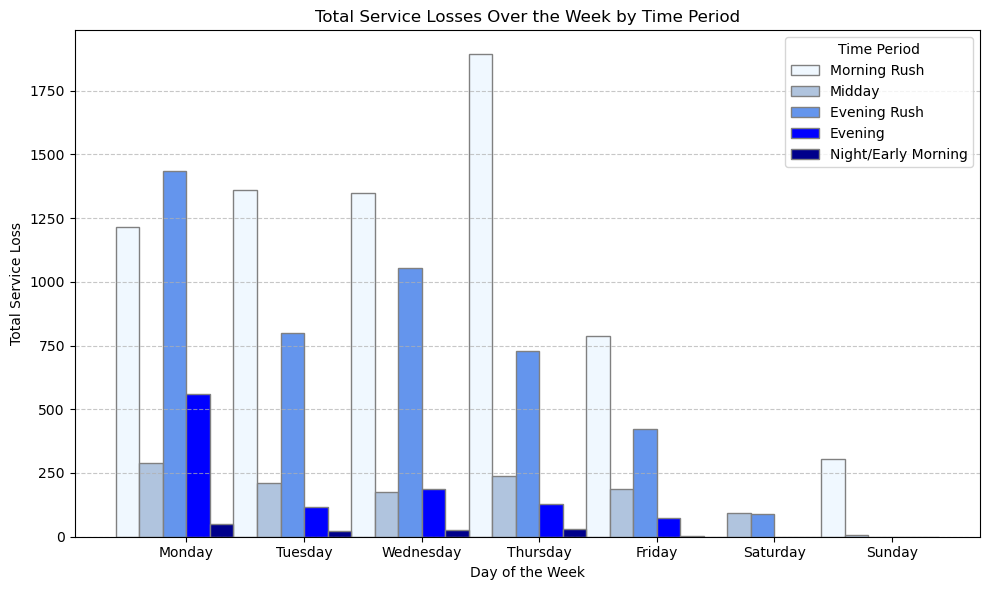

In [11]:
# total service loss
# add "Time Period" coulmn to each dataframe for grouping
morning_rush_results_df["Time Period"] = "Morning Rush"
midday_results_df["Time Period"] = "Midday"
evening_rush_results_df["Time Period"] = "Evening Rush"
evening_results_df["Time Period"] = "Evening"
night_early_morning_results_df["Time Period"] = "Night/Early Morning"

# combine all results
all_results_df = pd.concat([morning_rush_results_df, midday_results_df, evening_rush_results_df, evening_results_df, night_early_morning_results_df])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Midday", "Evening Rush", "Evening", "Night/Early Morning"]
all_results_df["Time Period"] = pd.Categorical(all_results_df["Time Period"], categories = time_period_order, ordered = True)

# aggregate total service losses by day of the week and time period
aggregated_data = all_results_df.groupby(["Day of Week", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)

# set order for "Day of Week" labels
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
aggregated_data = aggregated_data.reindex(day_order)

# add colors
color_palette = ["aliceblue", "lightsteelblue", "cornflowerblue", "blue", "darkblue"]

# plot grouped bar chart
plt.figure(figsize = (10, 6))

# set width of bar
bar_width = 0.2

# set position of bar on x-axis
r = np.arange(len(day_order))

# plot bars for each time period
for i, period in enumerate(time_period_order):
    plt.bar(r + i*bar_width, aggregated_data[period], color = color_palette[i], width = bar_width, edgecolor = "grey", label = period)

plt.xlabel("Day of the Week")
plt.ylabel("Total Service Loss")
plt.title("Total Service Losses Over the Week by Time Period")
plt.xticks([r + bar_width*(len(time_period_order)/2) for r in range(len(day_order))], day_order)
plt.legend(title = "Time Period")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.show()

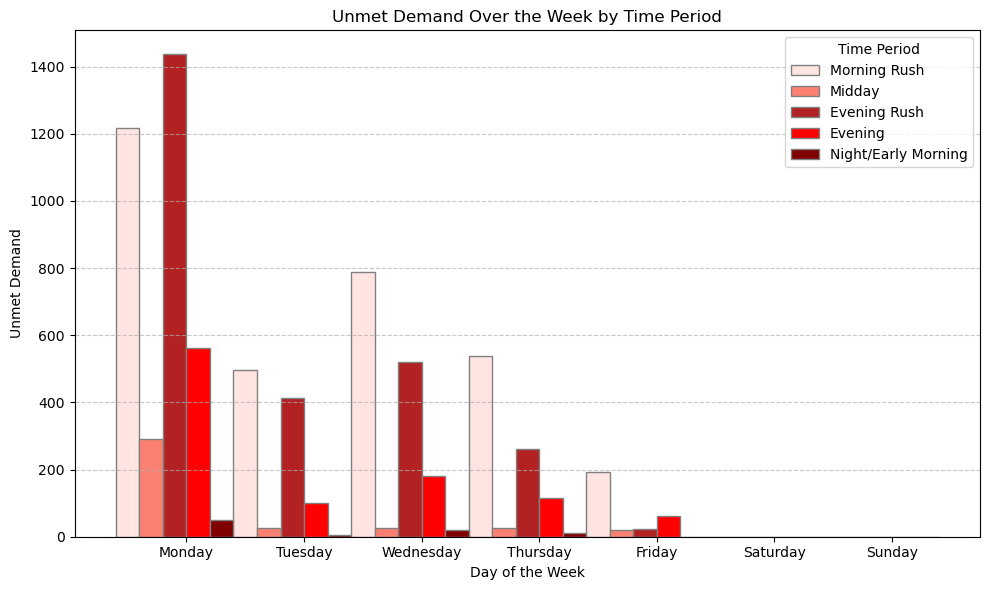

In [12]:
# unmet demand
# add "Time Period" coulmn to each dataframe for grouping
morning_rush_results_df["Time Period"] = "Morning Rush"
midday_results_df["Time Period"] = "Midday"
evening_rush_results_df["Time Period"] = "Evening Rush"
evening_results_df["Time Period"] = "Evening"
night_early_morning_results_df["Time Period"] = "Night/Early Morning"

# combine all results
all_results_df = pd.concat([morning_rush_results_df, midday_results_df, evening_rush_results_df, evening_results_df, night_early_morning_results_df])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Midday", "Evening Rush", "Evening", "Night/Early Morning"]
all_results_df["Time Period"] = pd.Categorical(all_results_df["Time Period"], categories = time_period_order, ordered = True)

# aggregate total service losses by day of the week and time period
aggregated_data = all_results_df.groupby(["Day of Week", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)

# set order for "Day of Week" labels
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
aggregated_data = aggregated_data.reindex(day_order)

# add colors
color_palette = ["mistyrose", "salmon", "firebrick", "red", "maroon"]

# plot grouped bar chart
plt.figure(figsize = (10, 6))

# set width of bar
bar_width = 0.2

# set position of bar on x-axis
r = np.arange(len(day_order))

# plot bars for each time period
for i, period in enumerate(time_period_order):
    plt.bar(r + i*bar_width, aggregated_data[period], color = color_palette[i], width = bar_width, edgecolor = "grey", label = period)

plt.xlabel("Day of the Week")
plt.ylabel("Unmet Demand")
plt.title("Unmet Demand Over the Week by Time Period")
plt.xticks([r + bar_width*(len(time_period_order)/2) for r in range(len(day_order))], day_order)
plt.legend(title = "Time Period")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.show()

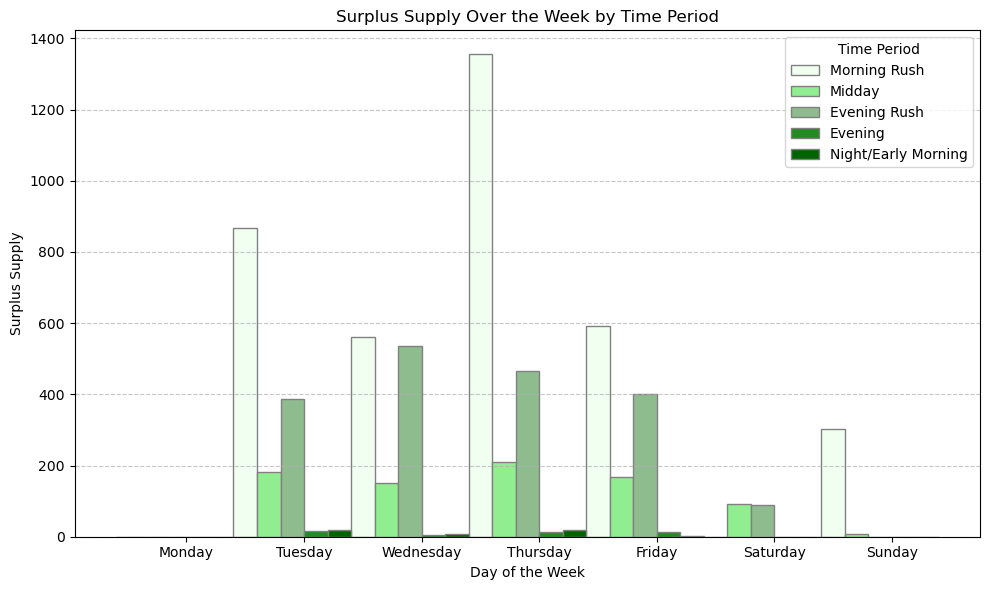

In [13]:
# surplus supply 
# add "Time Period" coulmn to each dataframe for grouping
morning_rush_results_df["Time Period"] = "Morning Rush"
midday_results_df["Time Period"] = "Midday"
evening_rush_results_df["Time Period"] = "Evening Rush"
evening_results_df["Time Period"] = "Evening"
night_early_morning_results_df["Time Period"] = "Night/Early Morning"

# combine all results
all_results_df = pd.concat([morning_rush_results_df, midday_results_df, evening_rush_results_df, evening_results_df, night_early_morning_results_df])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Midday", "Evening Rush", "Evening", "Night/Early Morning"]
all_results_df["Time Period"] = pd.Categorical(all_results_df["Time Period"], categories = time_period_order, ordered = True)

# aggregate total service losses by day of the week and time period
aggregated_data = all_results_df.groupby(["Day of Week", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)

# set order for "Day of Week" labels
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
aggregated_data = aggregated_data.reindex(day_order)

# add colors
color_palette = ["honeydew", "lightgreen", "darkseagreen", "forestgreen", "darkgreen"]

# plot grouped bar chart
plt.figure(figsize = (10, 6))

# set width of bar
bar_width = 0.2

# set position of bar on x-axis
r = np.arange(len(day_order))

# plot bars for each time period
for i, period in enumerate(time_period_order):
    plt.bar(r + i*bar_width, aggregated_data[period], color = color_palette[i], width = bar_width, edgecolor = "grey", label = period)

plt.xlabel("Day of the Week")
plt.ylabel("Surplus Supply")
plt.title("Surplus Supply Over the Week by Time Period")
plt.xticks([r + bar_width*(len(time_period_order)/2) for r in range(len(day_order))], day_order)
plt.legend(title = "Time Period")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.show()

#### No Rebalancing for Dynamic Lot Sizing Model

In [14]:
# no rebalancing model
def no_rebalancing(df):

    # define the number of stations
    stations = df["Station Name"].unique()
    L = len(stations)

    # define the time period
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    N = len(days)    

    # extract station capacities
    station_capacities = df.groupby("Station Name")["Station Capacity"].first().to_dict()

    # extract net flow values into a matrix
    net_flow_matrix = df.pivot(index = "Station Name", columns = "Day of Week", values = "Net Flow").fillna(0)
    net_flow_matrix = net_flow_matrix.reindex(columns = days).fillna(0).values

    # initialize arrays to store values
    I = np.zeros((L, N + 1))
    U = np.zeros((L, N))  
    S = np.zeros((L, N)) 

    # create an empty list to store data for the final dataframe
    data_list = []

    for i in range(L):
        station_name = stations[i]  # Get station names
        station_capacity = station_capacities[station_name]
        
        # set initial inventory
        I[i][0] = station_capacity // 2
        
        for t in range(N):
            current_inventory = I[i][t]
            net_flow = net_flow_matrix[i][t]
            
            # positive net flow means more bikes are leaving than arriving
            if net_flow > 0:
                # calculate unmet demand
                if net_flow > current_inventory:
                    U[i][t] = net_flow - current_inventory
                    new_inventory = 0
                else:
                    new_inventory = current_inventory - net_flow
            else:
                # negative net flow means more bikes are arriving than leaving
                new_inventory = current_inventory - net_flow
            
            # calculate surplus supply
            if new_inventory > station_capacity:
                S[i][t] = new_inventory - station_capacity
                new_inventory = station_capacity
            
            # update inventory for next period
            I[i][t+1] = new_inventory

            # append the values to the data list
            data_list.append({
                "Station Name": station_name,
                "Day of Week": days[t],
                "Inventory": current_inventory,
                "Net Flow": net_flow,
                "Unmet Demand": U[i][t],
                "Surplus Supply": S[i][t],
                "Total Service Loss": U[i][t] + S[i][t]
            })

    # convert the data list to a df
    result_df = pd.DataFrame(data_list)

    # create a sorting key for days of the week
    day_order = {day: i for i, day in enumerate(days)}
    
    # sort the df by "Station Name" and "Day of Week"
    result_df = result_df.sort_values(["Station Name", "Day of Week"], 
                                      key = lambda x: x.map(day_order) if x.name == "Day of Week" else x)
    # reset index
    result_df = result_df.reset_index(drop=True)

    # display df
    return result_df

In [15]:
# display results of no rebalancing over the week
# print("Morning Rush:")
morning_rush_no_rebalance = no_rebalancing(df_morning_rush)
# display(morning_rush_no_rebalance)

# print("Midday:")
midday_no_rebalance = no_rebalancing(df_midday)
# display(midday_no_rebalance)

# print("Evening Rush:")
evening_rush_no_rebalance = no_rebalancing(df_evening_rush)
# display(evening_rush_no_rebalance)

# print("Evening:")
evening_no_rebalance = no_rebalancing(df_evening)
# display(evening_no_rebalance)

# print("Night/Early Morning:")
night_early_morning_no_rebalance = no_rebalancing(df_night_early_morning)
# display(night_early_morning_no_rebalance)

#### Results of No Rebalancing for Dynamic Lot Sizing Model

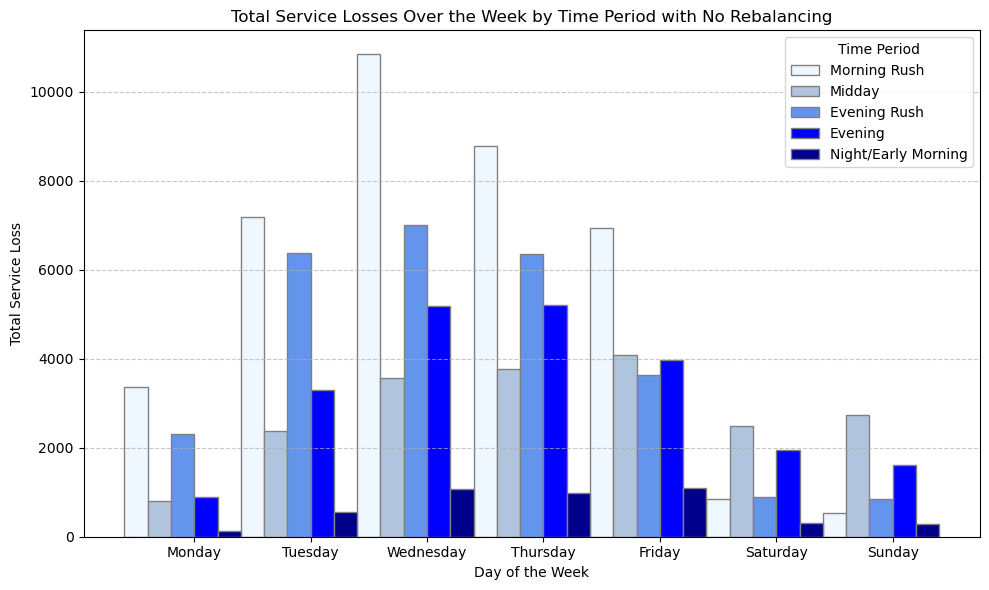

In [16]:
# total service loss no rebalancing
# add "Time Period" coulmn to each dataframe for grouping
morning_rush_no_rebalance["Time Period"] = "Morning Rush"
midday_no_rebalance["Time Period"] = "Midday"
evening_rush_no_rebalance["Time Period"] = "Evening Rush"
evening_no_rebalance["Time Period"] = "Evening"
night_early_morning_no_rebalance["Time Period"] = "Night/Early Morning"

# combine all results
all_results_df_no = pd.concat([morning_rush_no_rebalance, midday_no_rebalance, evening_rush_no_rebalance, evening_no_rebalance, night_early_morning_no_rebalance])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Midday", "Evening Rush", "Evening", "Night/Early Morning"]
all_results_df_no["Time Period"] = pd.Categorical(all_results_df_no["Time Period"], categories = time_period_order, ordered = True)

# aggregate total service losses by day of the week and time period
aggregated_data_no = all_results_df_no.groupby(["Day of Week", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)

# set order for "Day of Week" labels
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
aggregated_data_no = aggregated_data_no.reindex(day_order)

# add colors
color_palette = ["aliceblue", "lightsteelblue", "cornflowerblue", "blue", "darkblue"]

# plot grouped bar chart
plt.figure(figsize = (10, 6))

# set width of bar
bar_width = 0.2

# set position of bar on x-axis
r = np.arange(len(day_order))

# plot bars for each time period
for i, period in enumerate(time_period_order):
    plt.bar(r + i*bar_width, aggregated_data_no[period], color = color_palette[i], width = bar_width, edgecolor = "grey", label = period)

plt.xlabel("Day of the Week")
plt.ylabel("Total Service Loss")
plt.title("Total Service Losses Over the Week by Time Period with No Rebalancing")
plt.xticks([r + bar_width*(len(time_period_order)/2) for r in range(len(day_order))], day_order)
plt.legend(title = "Time Period")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.show()

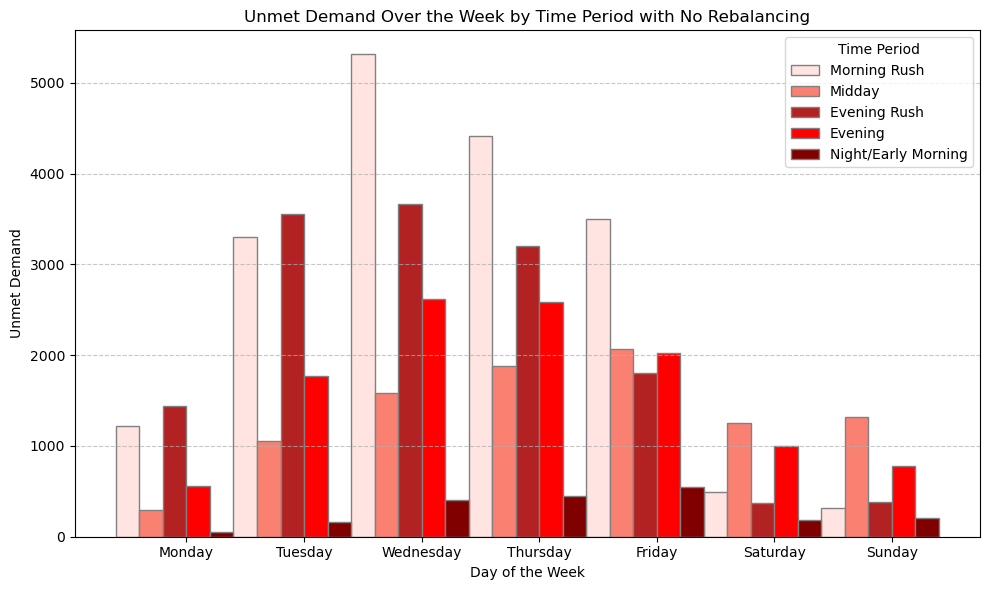

In [17]:
# unmet demand no rebalancing
# add "Time Period" coulmn to each dataframe for grouping
morning_rush_no_rebalance["Time Period"] = "Morning Rush"
midday_no_rebalance["Time Period"] = "Midday"
evening_rush_no_rebalance["Time Period"] = "Evening Rush"
evening_no_rebalance["Time Period"] = "Evening"
night_early_morning_no_rebalance["Time Period"] = "Night/Early Morning"

# combine all results
all_results_df_no = pd.concat([morning_rush_no_rebalance, midday_no_rebalance, evening_rush_no_rebalance, evening_no_rebalance, night_early_morning_no_rebalance])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Midday", "Evening Rush", "Evening", "Night/Early Morning"]
all_results_df_no["Time Period"] = pd.Categorical(all_results_df_no["Time Period"], categories = time_period_order, ordered = True)

# aggregate total service losses by day of the week and time period
aggregated_data_no = all_results_df_no.groupby(["Day of Week", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)

# set order for "Day of Week" labels
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
aggregated_data_no = aggregated_data_no.reindex(day_order)

# add colors
color_palette = ["mistyrose", "salmon", "firebrick", "red", "maroon"]

# plot grouped bar chart
plt.figure(figsize = (10, 6))

# set width of bar
bar_width = 0.2

# set position of bar on x-axis
r = np.arange(len(day_order))

# plot bars for each time period
for i, period in enumerate(time_period_order):
    plt.bar(r + i*bar_width, aggregated_data_no[period], color = color_palette[i], width = bar_width, edgecolor = "grey", label = period)

plt.xlabel("Day of the Week")
plt.ylabel("Unmet Demand")
plt.title("Unmet Demand Over the Week by Time Period with No Rebalancing")
plt.xticks([r + bar_width*(len(time_period_order)/2) for r in range(len(day_order))], day_order)
plt.legend(title = "Time Period")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.show()

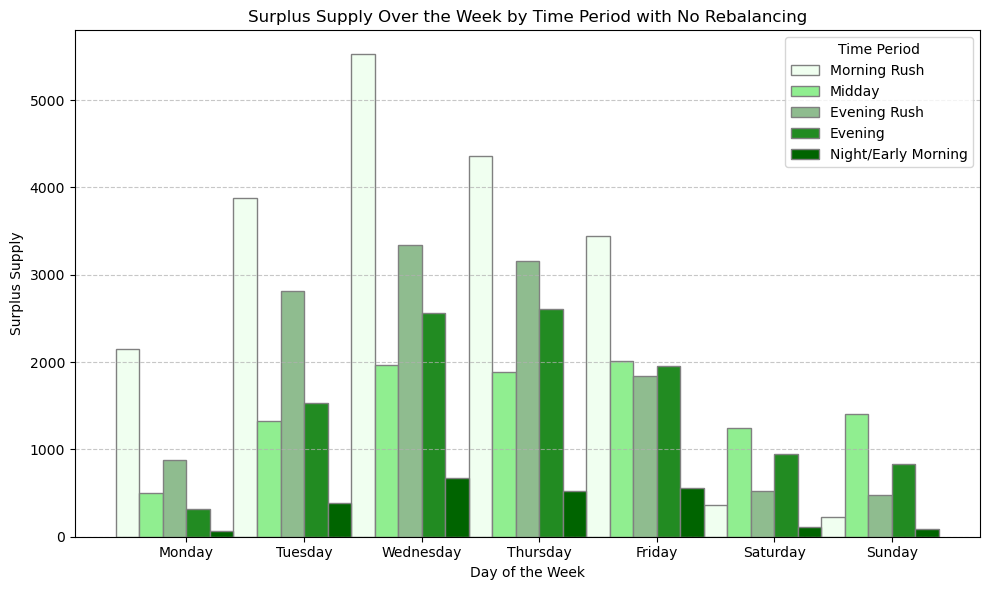

In [18]:
# surplus supply no rebalancing
# add "Time Period" coulmn to each dataframe for grouping
morning_rush_no_rebalance["Time Period"] = "Morning Rush"
midday_no_rebalance["Time Period"] = "Midday"
evening_rush_no_rebalance["Time Period"] = "Evening Rush"
evening_no_rebalance["Time Period"] = "Evening"
night_early_morning_no_rebalance["Time Period"] = "Night/Early Morning"

# combine all results
all_results_df_no = pd.concat([morning_rush_no_rebalance, midday_no_rebalance, evening_rush_no_rebalance, evening_no_rebalance, night_early_morning_no_rebalance])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Midday", "Evening Rush", "Evening", "Night/Early Morning"]
all_results_df_no["Time Period"] = pd.Categorical(all_results_df_no["Time Period"], categories = time_period_order, ordered = True)

# aggregate total service losses by day of the week and time period
aggregated_data_no = all_results_df_no.groupby(["Day of Week", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)

# set order for "Day of Week" labels
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
aggregated_data_no = aggregated_data_no.reindex(day_order)

# add colors
color_palette = ["honeydew", "lightgreen", "darkseagreen", "forestgreen", "darkgreen"]

# plot grouped bar chart
plt.figure(figsize = (10, 6))

# set width of bar
bar_width = 0.2

# set position of bar on x-axis
r = np.arange(len(day_order))

# plot bars for each time period
for i, period in enumerate(time_period_order):
    plt.bar(r + i*bar_width, aggregated_data_no[period], color = color_palette[i], width = bar_width, edgecolor = "grey", label = period)

plt.xlabel("Day of the Week")
plt.ylabel("Surplus Supply")
plt.title("Surplus Supply Over the Week by Time Period with No Rebalancing")
plt.xticks([r + bar_width*(len(time_period_order)/2) for r in range(len(day_order))], day_order)
plt.legend(title = "Time Period")
plt.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.show()

In [19]:
# percent changes
# rebalancing
all_results_df = pd.concat([morning_rush_results_df, midday_results_df, evening_rush_results_df, evening_results_df, night_early_morning_results_df])
time_period_order = ["Morning Rush", "Midday", "Evening Rush", "Evening", "Night/Early Morning"]
all_results_df["Time Period"] = pd.Categorical(all_results_df["Time Period"], categories = time_period_order, ordered = True)

# no rebalancing
all_results_df_no = pd.concat([morning_rush_no_rebalance, midday_no_rebalance, evening_rush_no_rebalance, evening_no_rebalance, night_early_morning_no_rebalance])
all_results_df_no["Time Period"] = pd.Categorical(all_results_df_no["Time Period"], categories = time_period_order, ordered = True)

aggregated_data_total = all_results_df.groupby(["Day of Week", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)
aggregated_data_no_total = all_results_df_no.groupby(["Day of Week", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)
aggregated_data_unmet_demand = all_results_df.groupby(["Day of Week", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)
aggregated_data_no_unmet_demand = all_results_df_no.groupby(["Day of Week", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)
aggregated_data_surplus_supply= all_results_df.groupby(["Day of Week", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)
aggregated_data_no_surplus_supply = all_results_df_no.groupby(["Day of Week", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)

total_service_loss_with_rebalance = aggregated_data_total.sum().sum()
total_service_loss_no_rebalance = aggregated_data_no_total.sum().sum()
unmet_demand_with_rebalance = aggregated_data_unmet_demand.sum().sum()
unmet_demand_no_rebalance = aggregated_data_no_unmet_demand.sum().sum()
surplus_supply_with_rebalance = aggregated_data_surplus_supply.sum().sum()
surplus_supply_no_rebalance = aggregated_data_no_surplus_supply.sum().sum()

overall_percent_change_total = ((total_service_loss_with_rebalance - total_service_loss_no_rebalance) / total_service_loss_no_rebalance) * 100
overall_percent_change_unmet_demand = ((unmet_demand_with_rebalance - unmet_demand_no_rebalance) / unmet_demand_no_rebalance) * 100
overall_percent_change_surplus_supply = ((surplus_supply_with_rebalance - surplus_supply_no_rebalance) / surplus_supply_no_rebalance) * 100

print("The total service loss has decreased by", np.round(overall_percent_change_total, 2), "%")
print("Unmet demand has decreased by", np.round(overall_percent_change_unmet_demand, 2), "%")
print("Surplus supply has decreased by", np.round(overall_percent_change_surplus_supply, 2), "%")

The total service loss has decreased by -87.67 %
Unmet demand has decreased by -86.77 %
Surplus supply has decreased by -88.56 %


#### Minimum Cost Flow Model

In [20]:
# filter data for one day of the week over one time period
monday_morning_rush_data = df_morning_rush[df_morning_rush["Day of Week"] == "Monday"]
monday_evenining_rush_data = df_evening_rush[df_evening_rush["Day of Week"] == "Monday"]
wednesday_morning_rush_data = df_morning_rush[df_morning_rush["Day of Week"] == "Wednesday"]
wednesday_evening_rush_data = df_evening_rush[df_evening_rush["Day of Week"] == "Wednesday"]
thursday_morning_rush_data = df_morning_rush[df_morning_rush["Day of Week"] == "Thursday"]
thursday_evening_rush_data = df_evening_rush[df_evening_rush["Day of Week"] == "Thursday"]

# group data by "Cluster"
clusters_monday_morning_rush = monday_morning_rush_data.groupby("Cluster")
clusters_monday_evening_rush = monday_evenining_rush_data.groupby("Cluster")
clusters_wednesday_morning_rush = wednesday_morning_rush_data.groupby("Cluster")
clusters_wednesday_evening_rush = wednesday_evening_rush_data.groupby("Cluster")
clusters_thursday_morning_rush = thursday_morning_rush_data.groupby("Cluster")
clusters_thursday_evening_rush = thursday_evening_rush_data.groupby("Cluster")


# create and store new dataframes for each cluster
dataframes_monday_morning_rush = {} 
dataframes_monday_evening_rush = {} 
dataframes_wednesday_morning_rush = {} 
dataframes_wednesday_evening_rush = {} 
dataframes_thursday_morning_rush = {} 
dataframes_thursday_evening_rush = {} 

for cluster_id, cluster_df in clusters_monday_morning_rush:
    dataframes_monday_morning_rush[f"Cluster {cluster_id}"] = cluster_df.reset_index(drop = True)

for cluster_id, cluster_df in clusters_monday_evening_rush:
    dataframes_monday_evening_rush[f"Cluster {cluster_id}"] = cluster_df.reset_index(drop = True)

for cluster_id, cluster_df in clusters_wednesday_morning_rush:
    dataframes_wednesday_morning_rush[f"Cluster {cluster_id}"] = cluster_df.reset_index(drop = True)

for cluster_id, cluster_df in clusters_wednesday_evening_rush:
    dataframes_wednesday_evening_rush[f"Cluster {cluster_id}"] = cluster_df.reset_index(drop = True)

for cluster_id, cluster_df in clusters_thursday_morning_rush:
    dataframes_thursday_morning_rush[f"Cluster {cluster_id}"] = cluster_df.reset_index(drop = True)

for cluster_id, cluster_df in clusters_thursday_evening_rush:
    dataframes_thursday_evening_rush[f"Cluster {cluster_id}"] = cluster_df.reset_index(drop = True)

In [21]:
# get all clusters from cluster dictionary
monday_morning_rush_cluster0 = dataframes_monday_morning_rush.get("Cluster 0")
monday_morning_rush_cluster1 = dataframes_monday_morning_rush.get("Cluster 1")
monday_morning_rush_cluster2 = dataframes_monday_morning_rush.get("Cluster 2")
monday_morning_rush_cluster3 = dataframes_monday_morning_rush.get("Cluster 3")
monday_morning_rush_cluster4 = dataframes_monday_morning_rush.get("Cluster 4")
monday_morning_rush_cluster5 = dataframes_monday_morning_rush.get("Cluster 5")
monday_morning_rush_cluster6 = dataframes_monday_morning_rush.get("Cluster 6")

monday_evening_rush_cluster0 = dataframes_monday_evening_rush.get("Cluster 0")
monday_evening_rush_cluster1 = dataframes_monday_evening_rush.get("Cluster 1")
monday_evening_rush_cluster2 = dataframes_monday_evening_rush.get("Cluster 2")
monday_evening_rush_cluster3 = dataframes_monday_evening_rush.get("Cluster 3")
monday_evening_rush_cluster4 = dataframes_monday_evening_rush.get("Cluster 4")
monday_evening_rush_cluster5 = dataframes_monday_evening_rush.get("Cluster 5")
monday_evening_rush_cluster6 = dataframes_monday_evening_rush.get("Cluster 6")

wednesday_morning_rush_cluster0 = dataframes_wednesday_morning_rush.get("Cluster 0")
wednesday_morning_rush_cluster1 = dataframes_wednesday_morning_rush.get("Cluster 1")
wednesday_morning_rush_cluster2 = dataframes_wednesday_morning_rush.get("Cluster 2")
wednesday_morning_rush_cluster3 = dataframes_wednesday_morning_rush.get("Cluster 3")
wednesday_morning_rush_cluster4 = dataframes_wednesday_morning_rush.get("Cluster 4")
wednesday_morning_rush_cluster5 = dataframes_wednesday_morning_rush.get("Cluster 5")
wednesday_morning_rush_cluster6 = dataframes_wednesday_morning_rush.get("Cluster 6")

wednesday_evening_rush_cluster0 = dataframes_wednesday_evening_rush.get("Cluster 0")
wednesday_evening_rush_cluster1 = dataframes_wednesday_evening_rush.get("Cluster 1")
wednesday_evening_rush_cluster2 = dataframes_wednesday_evening_rush.get("Cluster 2")
wednesday_evening_rush_cluster3 = dataframes_wednesday_evening_rush.get("Cluster 3")
wednesday_evening_rush_cluster4 = dataframes_wednesday_evening_rush.get("Cluster 4")
wednesday_evening_rush_cluster5 = dataframes_wednesday_evening_rush.get("Cluster 5")
wednesday_evening_rush_cluster6 = dataframes_wednesday_evening_rush.get("Cluster 6")

thursday_morning_rush_cluster0 = dataframes_thursday_morning_rush.get("Cluster 0")
thursday_morning_rush_cluster1 = dataframes_thursday_morning_rush.get("Cluster 1")
thursday_morning_rush_cluster2 = dataframes_thursday_morning_rush.get("Cluster 2")
thursday_morning_rush_cluster3 = dataframes_thursday_morning_rush.get("Cluster 3")
thursday_morning_rush_cluster4 = dataframes_thursday_morning_rush.get("Cluster 4")
thursday_morning_rush_cluster5 = dataframes_thursday_morning_rush.get("Cluster 5")
thursday_morning_rush_cluster6 = dataframes_thursday_morning_rush.get("Cluster 6")

thursday_evening_rush_cluster0 = dataframes_thursday_evening_rush.get("Cluster 0")
thursday_evening_rush_cluster1 = dataframes_thursday_evening_rush.get("Cluster 1")
thursday_evening_rush_cluster2 = dataframes_thursday_evening_rush.get("Cluster 2")
thursday_evening_rush_cluster3 = dataframes_thursday_evening_rush.get("Cluster 3")
thursday_evening_rush_cluster4 = dataframes_thursday_evening_rush.get("Cluster 4")
thursday_evening_rush_cluster5 = dataframes_thursday_evening_rush.get("Cluster 5")
thursday_evening_rush_cluster6 = dataframes_thursday_evening_rush.get("Cluster 6")

In [22]:
# calculates the distance between two points using their latitide and longitude (Haversine formula)
def haversine_distance(lat1, lon1, lat2, lon2):

    R = 6371 # Earth's radius in kilometers
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)

    a = sin(delta_phi / 2) ** 2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2) ** 2
    c = 2 * asin(sqrt(a))
    distance_km = R * c

    return np.round(distance_km, 2)

# creates a network representation of the bike rebalancing problem
def create_network(df):
    
    # initialize an empty graph
    G = nx.DiGraph()

    # initialize an empty dictionary to store station coordinates
    station_coords = {}

    # iterate over each row in the dataframe to add nodes for each station and date
    for _, row in df.iterrows():
        station_name = row["Station Name"]
        lat = row["Latitude"]
        lon = row["Longitude"]

        # store station coordinates
        if station_name not in station_coords:
            station_coords[station_name] = (lat, lon)

        node_name = f"{station_name}"  # unique node identifier
        G.add_node(node_name)  # add node to graph

        # extract attributes from the row
        capacity = row["Station Capacity"]  # extract station capacity
        net_flow = row.get("Net Flow", 0)  # extract net flow, default to 0 if not present

        # assign attributes as node attributes
        G.nodes[node_name]["Capacity"] = capacity
        G.nodes[node_name]["Inventory"] = capacity // 2
        G.nodes[node_name]["Net Flow"] = net_flow

    # add directed edges between different stations for rebalancing with distances as weights
    station_names = df["Station Name"].unique()
    for i in range(len(station_names)):
        for j in range(len(station_names)):
            if i != j:
                station1 = station_names[i]
                station2 = station_names[j]
                lat1, lon1 = station_coords[station1]
                lat2, lon2 = station_coords[station2]
                distance = haversine_distance(lat1, lon1, lat2, lon2)

                node1 = f"{station1}"
                node2 = f"{station2}"
                G.add_edge(node1, node2, weight=distance, capacity=20)  # add directed edge with distance as weight and 20 flow capacity

    # return graph
    return G

In [23]:
# # define graph
# G = create_network(cluster_0_df)

# # get the first 5 nodes from the graph
# first_5_nodes = list(G.nodes())[:5]
# H = G.subgraph(first_5_nodes)

# # plot graph
# plt.figure(figsize = (12, 8))
# pos = nx.spring_layout(H) 
# nx.draw(H, pos, with_labels = True, node_size = 500, node_color = "lightblue", font_size = 7, font_color = "black", font_weight = "bold")
# nx.draw_networkx_edge_labels(H, pos, edge_labels={(u, v): f"{data["weight"]:.2f}" for u, v, data in H.edges(data=True)})
# plt.title("Network Representation of the First 5 Stations in Cluster 0")
# plt.show()

In [24]:
# minimum cost flow model
def minimum_cost_flow(df):

    # create network
    G = create_network(df)

    # get nodes and edges
    nodes = list(G.nodes())
    edges = list(G.edges())

    # initialize model
    model = gp.Model("MinimumCostFlow")
    model.Params.OutputFlag = 0  # suppress Gurobi output

    # initialize variables
    X = model.addVars(edges, vtype = GRB.INTEGER, name = "Flow")
    U = model.addVars(nodes, vtype = GRB.INTEGER, name = "UnmetDemand")
    S = model.addVars(nodes, vtype = GRB.INTEGER, name = "SurplusSupply")

    # define objective function
    obj = gp.quicksum(G[i][j]["weight"] * X[i, j] for i, j in edges) + gp.quicksum(1000 * (U[i] + S[i]) for i in nodes)
    model.setObjective(obj, GRB.MINIMIZE)

    # define constraints
    for i in nodes:

        RIN = gp.quicksum(X[j, i] for j in G.predecessors(i))
        ROUT = gp.quicksum(X[i, j] for j in G.successors(i))
        
        # flow balance constraint
        model.addConstr(RIN - ROUT + (U[i] - S[i]) == G.nodes[i].get("Net Flow", 0), f"flow_balance_{i}")

    # edge capacity constraint
    for i, j in edges:
        model.addConstr(X[i, j] <= G[i][j]["capacity"], f"capacity_{i}_{j}")

    # optimize model
    model.optimize()

    # get results
    if model.status == GRB.OPTIMAL:
        results = []

        # create a dictionary to store station metrics
        station_metrics = {
            i: {
                "Unmet Demand": int(U[i].x),
                "Surplus Supply": int(S[i].x),
                "Service Loss": int(U[i].x + S[i].x)
            }
            for i in nodes
        }

        # collect results
        for i in nodes:
            for j in G.successors(i):
                bikes_moved = X[i, j].x
                if bikes_moved > 0:
                    cost = G[i][j]["weight"] * bikes_moved
                    unmet_demand = station_metrics[i]["Unmet Demand"]
                    surplus_supply = station_metrics[i]["Surplus Supply"]
                    total_service_loss = station_metrics[i]["Service Loss"]
                    results.append([
                        i, j, int(bikes_moved), G[i][j]["weight"], cost,
                        unmet_demand, surplus_supply, total_service_loss
                    ])

        # add rows for source stations with no flows but have metrics
        for station in nodes:
            if not any(station == row[0] for row in results):
                results.append([
                    station, None, 0, 0, 0,
                    station_metrics[station]["Unmet Demand"],
                    station_metrics[station]["Surplus Supply"],
                    station_metrics[station]["Service Loss"]
                ])

        # return results as a df
        columns = ["From Station", "To Station", "Flow", "Distance", "Cost", "Unmet Demand", "Surplus Supply", "Total Service Loss"]
        combined_df = pd.DataFrame(results, columns=columns)
        return combined_df

    # compute IIS if infeasible
    else:
        print("\nThe model is infeasible. Computing IIS...")
        model.computeIIS()
        model.write("model.ilp")
        return None

In [25]:
# results for each df
monday_morning_rush_results0 = minimum_cost_flow(monday_morning_rush_cluster0)
monday_morning_rush_results1 = minimum_cost_flow(monday_morning_rush_cluster1)
monday_morning_rush_results2 = minimum_cost_flow(monday_morning_rush_cluster2)
monday_morning_rush_results3 = minimum_cost_flow(monday_morning_rush_cluster3)
monday_morning_rush_results4 = minimum_cost_flow(monday_morning_rush_cluster4)
monday_morning_rush_results5 = minimum_cost_flow(monday_morning_rush_cluster5)
monday_morning_rush_results6 = minimum_cost_flow(monday_morning_rush_cluster6)

monday_evening_rush_results0 = minimum_cost_flow(monday_evening_rush_cluster0)
monday_evening_rush_results1 = minimum_cost_flow(monday_evening_rush_cluster1)
monday_evening_rush_results2 = minimum_cost_flow(monday_evening_rush_cluster2)
monday_evening_rush_results3 = minimum_cost_flow(monday_evening_rush_cluster3)
monday_evening_rush_results4 = minimum_cost_flow(monday_evening_rush_cluster4)
monday_evening_rush_results5 = minimum_cost_flow(monday_evening_rush_cluster5)
monday_evening_rush_results6 = minimum_cost_flow(monday_evening_rush_cluster6)

wednesday_morning_rush_results0 = minimum_cost_flow(wednesday_morning_rush_cluster0)
wednesday_morning_rush_results1 = minimum_cost_flow(wednesday_morning_rush_cluster1)
wednesday_morning_rush_results2 = minimum_cost_flow(wednesday_morning_rush_cluster2)
wednesday_morning_rush_results3 = minimum_cost_flow(wednesday_morning_rush_cluster3)
wednesday_morning_rush_results4 = minimum_cost_flow(wednesday_morning_rush_cluster4)
wednesday_morning_rush_results5 = minimum_cost_flow(wednesday_morning_rush_cluster5)
wednesday_morning_rush_results6 = minimum_cost_flow(wednesday_morning_rush_cluster6)

wednesday_evening_rush_results0 = minimum_cost_flow(wednesday_evening_rush_cluster0)
wednesday_evening_rush_results1 = minimum_cost_flow(wednesday_evening_rush_cluster1)
wednesday_evening_rush_results2 = minimum_cost_flow(wednesday_evening_rush_cluster2)
wednesday_evening_rush_results3 = minimum_cost_flow(wednesday_evening_rush_cluster3)
wednesday_evening_rush_results4 = minimum_cost_flow(wednesday_evening_rush_cluster4)
wednesday_evening_rush_results5 = minimum_cost_flow(wednesday_evening_rush_cluster5)
wednesday_evening_rush_results6 = minimum_cost_flow(wednesday_evening_rush_cluster6)

thursday_morning_rush_results0 = minimum_cost_flow(wednesday_morning_rush_cluster0)
thursday_morning_rush_results1 = minimum_cost_flow(wednesday_morning_rush_cluster1)
thursday_morning_rush_results2 = minimum_cost_flow(wednesday_morning_rush_cluster2)
thursday_morning_rush_results3 = minimum_cost_flow(wednesday_morning_rush_cluster3)
thursday_morning_rush_results4 = minimum_cost_flow(wednesday_morning_rush_cluster4)
thursday_morning_rush_results5 = minimum_cost_flow(wednesday_morning_rush_cluster5)
thursday_morning_rush_results6 = minimum_cost_flow(wednesday_morning_rush_cluster6)

thursday_evening_rush_results0 = minimum_cost_flow(thursday_evening_rush_cluster0)
thursday_evening_rush_results1 = minimum_cost_flow(thursday_evening_rush_cluster1)
thursday_evening_rush_results2 = minimum_cost_flow(thursday_evening_rush_cluster2)
thursday_evening_rush_results3 = minimum_cost_flow(thursday_evening_rush_cluster3)
thursday_evening_rush_results4 = minimum_cost_flow(thursday_evening_rush_cluster4)
thursday_evening_rush_results5 = minimum_cost_flow(thursday_evening_rush_cluster5)
thursday_evening_rush_results6 = minimum_cost_flow(thursday_evening_rush_cluster6)

#### Results of Minimum Cost Flow Model

In [26]:
# add cluster label back to each df for grouping
monday_morning_rush_results0["Cluster"] = "0"
monday_morning_rush_results1["Cluster"] = "1"
monday_morning_rush_results2["Cluster"] = "2"
monday_morning_rush_results3["Cluster"] = "3"
monday_morning_rush_results4["Cluster"] = "4"
monday_morning_rush_results5["Cluster"] = "5"
monday_morning_rush_results6["Cluster"] = "6"

monday_evening_rush_results0["Cluster"] = "0"
monday_evening_rush_results1["Cluster"] = "1"
monday_evening_rush_results2["Cluster"] = "2"
monday_evening_rush_results3["Cluster"] = "3"
monday_evening_rush_results4["Cluster"] = "4"
monday_evening_rush_results5["Cluster"] = "5"
monday_evening_rush_results6["Cluster"] = "6"

wednesday_morning_rush_results0["Cluster"] = "0"
wednesday_morning_rush_results1["Cluster"] = "1"
wednesday_morning_rush_results2["Cluster"] = "2"
wednesday_morning_rush_results3["Cluster"] = "3"
wednesday_morning_rush_results4["Cluster"] = "4"
wednesday_morning_rush_results5["Cluster"] = "5"
wednesday_morning_rush_results6["Cluster"] = "6"

wednesday_evening_rush_results0["Cluster"] = "0"
wednesday_evening_rush_results1["Cluster"] = "1"
wednesday_evening_rush_results2["Cluster"] = "2"
wednesday_evening_rush_results3["Cluster"] = "3"
wednesday_evening_rush_results4["Cluster"] = "4"
wednesday_evening_rush_results5["Cluster"] = "5"
wednesday_evening_rush_results6["Cluster"] = "6"

thursday_morning_rush_results0["Cluster"] = "0"
thursday_morning_rush_results1["Cluster"] = "1"
thursday_morning_rush_results2["Cluster"] = "2"
thursday_morning_rush_results3["Cluster"] = "3"
thursday_morning_rush_results4["Cluster"] = "4"
thursday_morning_rush_results5["Cluster"] = "5"
thursday_morning_rush_results6["Cluster"] = "6"

thursday_evening_rush_results0["Cluster"] = "0"
thursday_evening_rush_results1["Cluster"] = "1"
thursday_evening_rush_results2["Cluster"] = "2"
thursday_evening_rush_results3["Cluster"] = "3"
thursday_evening_rush_results4["Cluster"] = "4"
thursday_evening_rush_results5["Cluster"] = "5"
thursday_evening_rush_results6["Cluster"] = "6"

In [27]:
# add "Time Period" coulmn to each dataframe for grouping
monday_morning_rush_results0["Time Period"] = "Morning Rush"
monday_morning_rush_results1["Time Period"] = "Morning Rush"
monday_morning_rush_results2["Time Period"] = "Morning Rush"
monday_morning_rush_results3["Time Period"] = "Morning Rush"
monday_morning_rush_results4["Time Period"] = "Morning Rush"
monday_morning_rush_results5["Time Period"] = "Morning Rush"
monday_morning_rush_results6["Time Period"] = "Morning Rush"

monday_evening_rush_results0["Time Period"] = "Evening Rush"
monday_evening_rush_results1["Time Period"] = "Evening Rush"
monday_evening_rush_results2["Time Period"] = "Evening Rush"
monday_evening_rush_results3["Time Period"] = "Evening Rush"
monday_evening_rush_results4["Time Period"] = "Evening Rush"
monday_evening_rush_results5["Time Period"] = "Evening Rush"
monday_evening_rush_results6["Time Period"] = "Evening Rush"

wednesday_morning_rush_results0["Time Period"] = "Morning Rush"
wednesday_morning_rush_results1["Time Period"] = "Morning Rush"
wednesday_morning_rush_results2["Time Period"] = "Morning Rush"
wednesday_morning_rush_results3["Time Period"] = "Morning Rush"
wednesday_morning_rush_results4["Time Period"] = "Morning Rush"
wednesday_morning_rush_results5["Time Period"] = "Morning Rush"
wednesday_morning_rush_results6["Time Period"] = "Morning Rush"

wednesday_evening_rush_results0["Time Period"] = "Evening Rush"
wednesday_evening_rush_results1["Time Period"] = "Evening Rush"
wednesday_evening_rush_results2["Time Period"] = "Evening Rush"
wednesday_evening_rush_results3["Time Period"] = "Evening Rush"
wednesday_evening_rush_results4["Time Period"] = "Evening Rush"
wednesday_evening_rush_results5["Time Period"] = "Evening Rush"
wednesday_evening_rush_results6["Time Period"] = "Evening Rush"

thursday_morning_rush_results0["Time Period"] = "Morning Rush"
thursday_morning_rush_results1["Time Period"] = "Morning Rush"
thursday_morning_rush_results2["Time Period"] = "Morning Rush"
thursday_morning_rush_results3["Time Period"] = "Morning Rush"
thursday_morning_rush_results4["Time Period"] = "Morning Rush"
thursday_morning_rush_results5["Time Period"] = "Morning Rush"
thursday_morning_rush_results6["Time Period"] = "Morning Rush"

thursday_evening_rush_results0["Time Period"] = "Evening Rush"
thursday_evening_rush_results1["Time Period"] = "Evening Rush"
thursday_evening_rush_results2["Time Period"] = "Evening Rush"
thursday_evening_rush_results3["Time Period"] = "Evening Rush"
thursday_evening_rush_results4["Time Period"] = "Evening Rush"
thursday_evening_rush_results5["Time Period"] = "Evening Rush"
thursday_evening_rush_results6["Time Period"] = "Evening Rush"


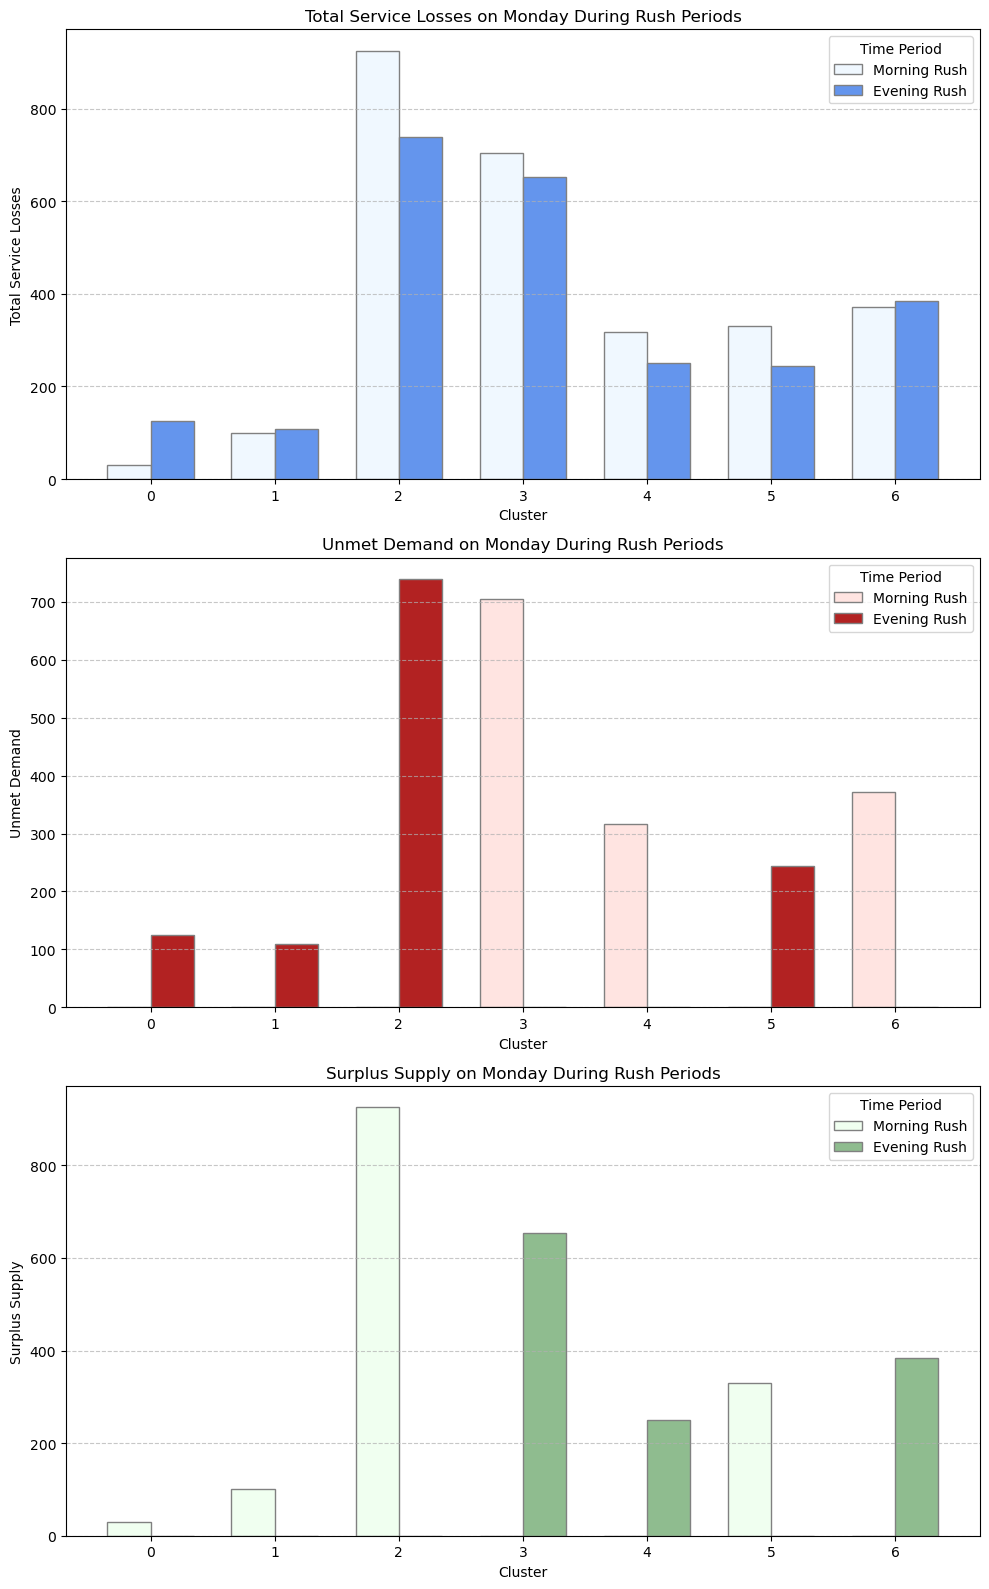

In [28]:
# Monday results
all_results_monday_df = pd.concat([
    monday_morning_rush_results0, monday_morning_rush_results1, monday_morning_rush_results2, 
    monday_morning_rush_results3, monday_morning_rush_results4, monday_morning_rush_results5, 
    monday_morning_rush_results6, monday_evening_rush_results0, monday_evening_rush_results1, 
    monday_evening_rush_results2, monday_evening_rush_results3, monday_evening_rush_results4, 
    monday_evening_rush_results5, monday_evening_rush_results6
])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Evening Rush"]
all_results_monday_df["Time Period"] = pd.Categorical(all_results_monday_df["Time Period"], categories = time_period_order, ordered = True)

# aggregate data 
aggregated_data_loss = all_results_monday_df.groupby(["Cluster", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)
aggregated_data_demand = all_results_monday_df.groupby(["Cluster", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)
aggregated_data_supply = all_results_monday_df.groupby(["Cluster", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)

# define colors for each subplot
color_palettes = [
    ["aliceblue", "cornflowerblue"],
    ["mistyrose", "firebrick"],
    ["honeydew", "darkseagreen"]
]

# create subplots
fig, axes = plt.subplots(3, 1, figsize = (10, 16))

# set width of bars
bar_width = 0.35

# create positions for the bars
r = np.arange(len(aggregated_data_loss))

# plot on separate subplots
for ax, data, title, colors in zip(axes, 
                                   [aggregated_data_loss, aggregated_data_demand, aggregated_data_supply], 
                                   ["Total Service Losses on Monday During Rush Periods", "Unmet Demand on Monday During Rush Periods", "Surplus Supply on Monday During Rush Periods"],
                                   color_palettes):
    for i, period in enumerate(time_period_order):
        ax.bar(r + i * bar_width, data[period], color = colors[i], width = bar_width, edgecolor = "grey", label = period)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(title.split(" on ")[0])
    ax.set_title(title)
    ax.set_xticks(r + bar_width / 2)
    ax.set_xticklabels(data.index)
    ax.legend(title="Time Period")
    ax.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.savefig("monday_total_loss.png", dpi = 300, bbox_inches = "tight")
plt.show()

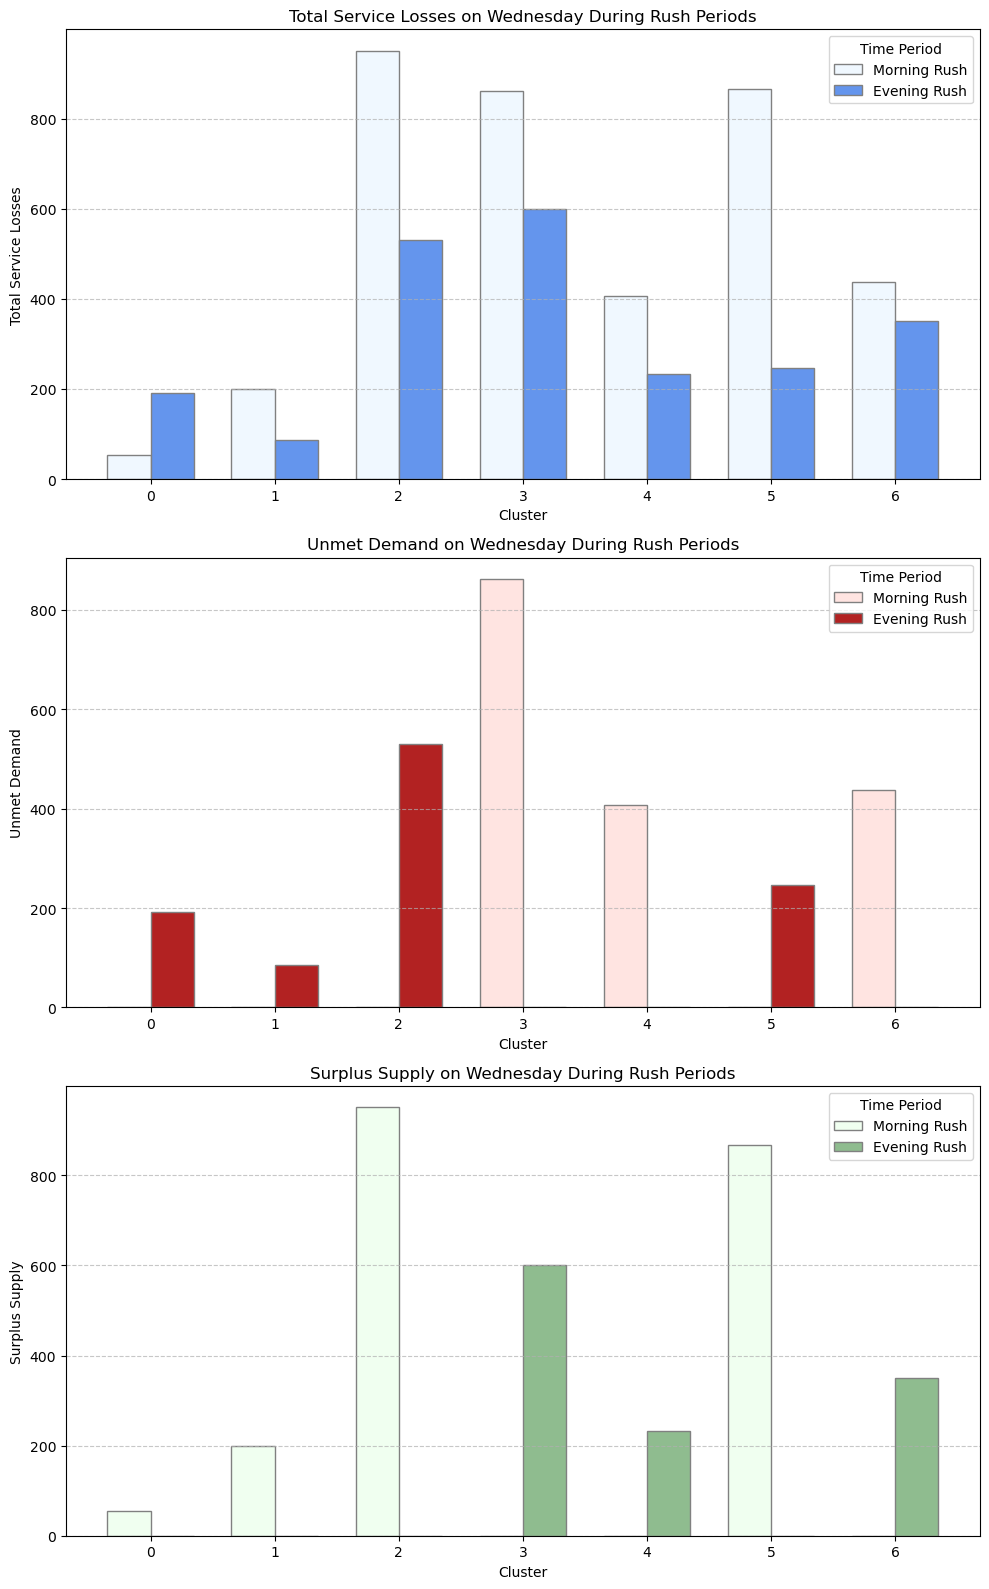

In [29]:
# Wednesday results
all_results_wednesday_df = pd.concat([
    wednesday_morning_rush_results0, wednesday_morning_rush_results1, wednesday_morning_rush_results2, 
    wednesday_morning_rush_results3, wednesday_morning_rush_results4, wednesday_morning_rush_results5, 
    wednesday_morning_rush_results6, wednesday_evening_rush_results0, wednesday_evening_rush_results1, 
    wednesday_evening_rush_results2, wednesday_evening_rush_results3, wednesday_evening_rush_results4, 
    wednesday_evening_rush_results5, wednesday_evening_rush_results6
])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Evening Rush"]
all_results_wednesday_df["Time Period"] = pd.Categorical(all_results_wednesday_df["Time Period"], categories = time_period_order, ordered = True)

# aggregate data 
aggregated_data_loss = all_results_wednesday_df.groupby(["Cluster", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)
aggregated_data_demand = all_results_wednesday_df.groupby(["Cluster", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)
aggregated_data_supply = all_results_wednesday_df.groupby(["Cluster", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)

# define colors for each subplot
color_palettes = [
    ["aliceblue", "cornflowerblue"],
    ["mistyrose", "firebrick"],
    ["honeydew", "darkseagreen"]
]

# create subplots
fig, axes = plt.subplots(3, 1, figsize = (10, 16))

# set width of bars
bar_width = 0.35

# create positions for the bars
r = np.arange(len(aggregated_data_loss))

# plot on separate subplots
for ax, data, title, colors in zip(axes, 
                                   [aggregated_data_loss, aggregated_data_demand, aggregated_data_supply], 
                                   ["Total Service Losses on Wednesday During Rush Periods", "Unmet Demand on Wednesday During Rush Periods", "Surplus Supply on Wednesday During Rush Periods"],
                                   color_palettes):
    for i, period in enumerate(time_period_order):
        ax.bar(r + i * bar_width, data[period], color = colors[i], width = bar_width, edgecolor = "grey", label = period)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(title.split(" on ")[0])  
    ax.set_title(title)
    ax.set_xticks(r + bar_width / 2)
    ax.set_xticklabels(data.index)
    ax.legend(title="Time Period")
    ax.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.savefig("wednesday_total_loss.png", dpi = 300, bbox_inches = "tight")
plt.show()

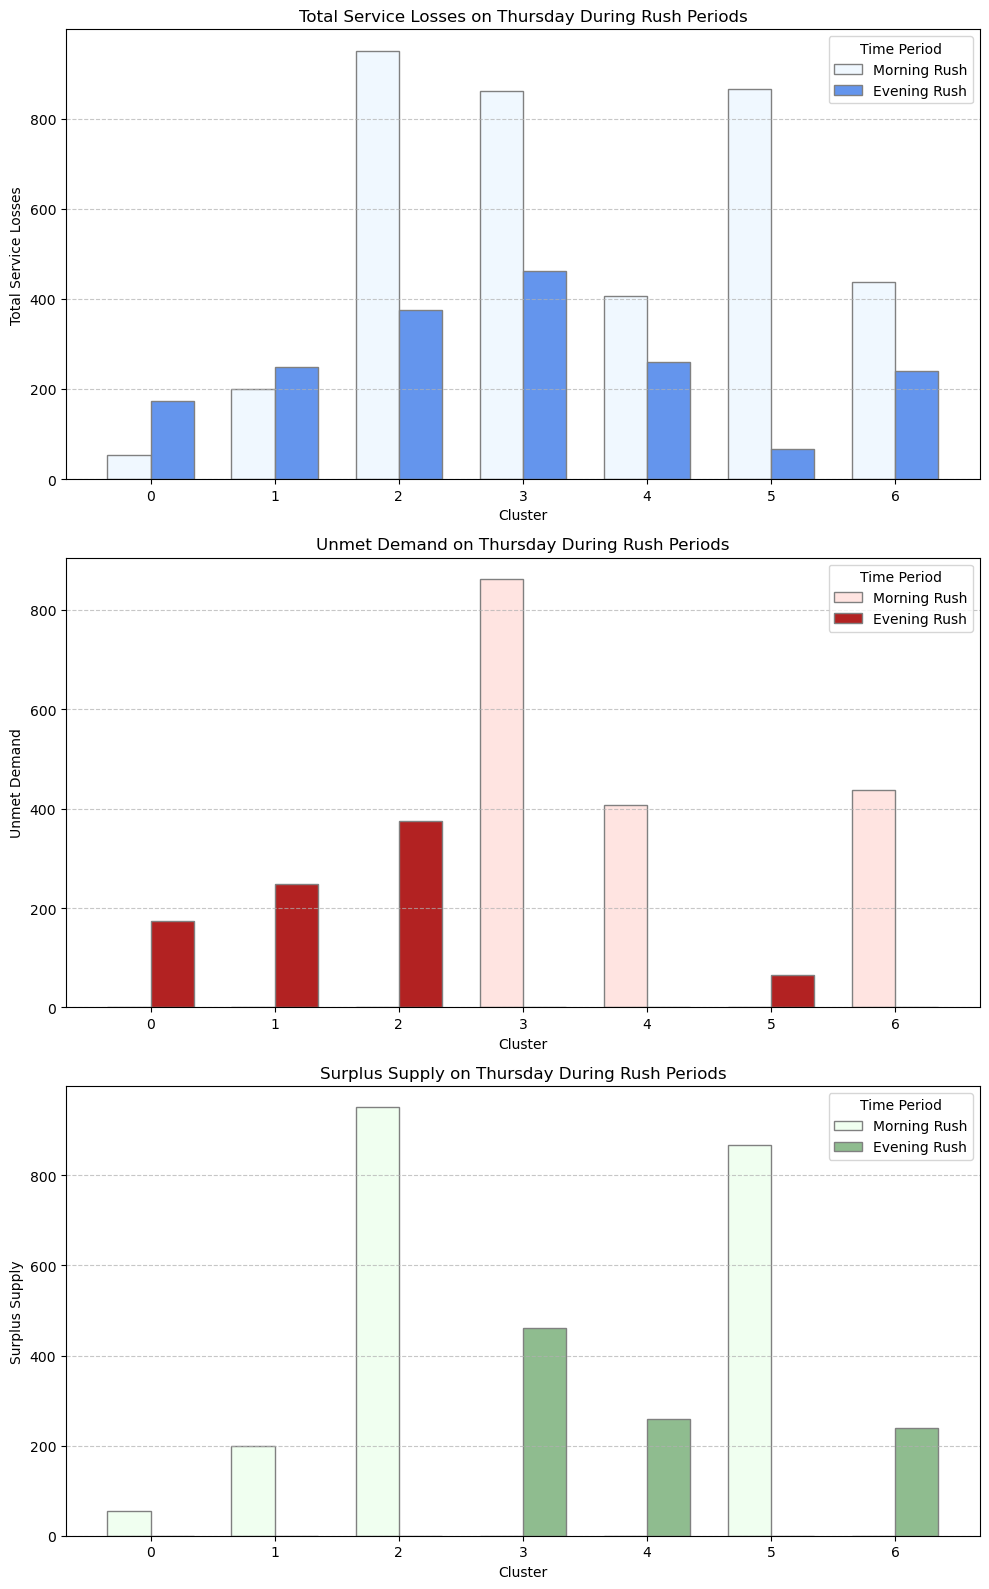

In [30]:
# Thursday results
# combine all results
all_results_thursday_df = pd.concat([
    thursday_morning_rush_results0, thursday_morning_rush_results1, thursday_morning_rush_results2, 
    thursday_morning_rush_results3, thursday_morning_rush_results4, thursday_morning_rush_results5, 
    thursday_morning_rush_results6, thursday_evening_rush_results0, thursday_evening_rush_results1, 
    thursday_evening_rush_results2, thursday_evening_rush_results3, thursday_evening_rush_results4, 
    thursday_evening_rush_results5, thursday_evening_rush_results6
])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Evening Rush"]
all_results_thursday_df["Time Period"] = pd.Categorical(all_results_thursday_df["Time Period"], categories = time_period_order, ordered = True)

# aggregate data 
aggregated_data_loss = all_results_thursday_df.groupby(["Cluster", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)
aggregated_data_demand = all_results_thursday_df.groupby(["Cluster", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)
aggregated_data_supply = all_results_thursday_df.groupby(["Cluster", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)

# define colors for each subplot
color_palettes = [
    ["aliceblue", "cornflowerblue"],
    ["mistyrose", "firebrick"],
    ["honeydew", "darkseagreen"]
]

# create subplots
fig, axes = plt.subplots(3, 1, figsize = (10, 16))

# set width of bars
bar_width = 0.35

# create positions for the bars
r = np.arange(len(aggregated_data_loss))

# plot on separate subplots
for ax, data, title, colors in zip(axes, 
                                   [aggregated_data_loss, aggregated_data_demand, aggregated_data_supply], 
                                   ["Total Service Losses on Thursday During Rush Periods", "Unmet Demand on Thursday During Rush Periods", "Surplus Supply on Thursday During Rush Periods"],
                                   color_palettes):
    for i, period in enumerate(time_period_order):
        ax.bar(r + i * bar_width, data[period], color = colors[i], width = bar_width, edgecolor = "grey", label = period)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(title.split(" on ")[0])  # Short label
    ax.set_title(title)
    ax.set_xticks(r + bar_width / 2)
    ax.set_xticklabels(data.index)
    ax.legend(title="Time Period")
    ax.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.savefig("thursday_total_loss.png", dpi = 300, bbox_inches = "tight")
plt.show()

#### No Rebalancing for Minimum Cost Flow

In [31]:
# minimum cost flow no rebalancing
def minimum_cost_flow_no_rebalancing(df):

    # create network
    G = create_network(df)

    # get nodes and edges
    nodes = list(G.nodes())
    edges = list(G.edges())

    # initialize model
    model = gp.Model("MinimumCostFlowNoRebalancing")
    model.Params.OutputFlag = 0 

    # initialize variables
    X = model.addVars(edges, vtype = GRB.INTEGER, name = "Flow")
    U = model.addVars(nodes, vtype = GRB.INTEGER, name = "UnmetDemand")
    S = model.addVars(nodes, vtype = GRB.INTEGER, name = "SurplusSupply")

    # define objective function
    obj = gp.quicksum(G[i][j]["weight"] * X[i, j] for i, j in edges) + gp.quicksum(1000 * (U[i] + S[i]) for i in nodes)
    model.setObjective(obj, GRB.MINIMIZE)

    # define constraints
    for i in nodes:
        RIN = gp.quicksum(X[j, i] for j in G.predecessors(i))
        ROUT = gp.quicksum(X[i, j] for j in G.successors(i))
        
        # flow balance constraint
        model.addConstr(RIN - ROUT + (U[i] - S[i]) == G.nodes[i].get("Net Flow", 0), f"flow_balance_{i}")

    # edge capacity constraint
    for i, j in edges:
        model.addConstr(X[i, j] <= G[i][j]["capacity"], f"capacity_{i}_{j}")

    # set flow to zero for no rebalancing
    for i, j in edges:
        model.addConstr(X[i, j] == 0, f"no_rebalancing_{i}_{j}")

    # optimize model
    model.optimize()

    # get results
    if model.status == GRB.OPTIMAL:
        results = []

        # create a dictionary to store station metrics
        station_metrics = {
            i: {
                "Unmet Demand": int(U[i].x),
                "Surplus Supply": int(S[i].x),
                "Service Loss": int(U[i].x + S[i].x)
            }
            for i in nodes
        }

        # collect results
        for i in nodes:
            results.append([
                i, None, 0, 0, 0,
                station_metrics[i]["Unmet Demand"],
                station_metrics[i]["Surplus Supply"],
                station_metrics[i]["Service Loss"]
            ])

        # return results as DataFrame
        columns = ["From Station", "To Station", "Flow", "Distance", "Cost", "Unmet Demand", "Surplus Supply", "Total Service Loss"]
        combined_df = pd.DataFrame(results, columns=columns)
        return combined_df

    # compute IIS if infeasible
    else:
        print("\nThe model is infeasible. Computing IIS...")
        model.computeIIS()
        model.write("model.ilp")
        return None

In [32]:
# get dfs for no rebalancing
no_monday_morning_rush_results0 = minimum_cost_flow_no_rebalancing(monday_morning_rush_cluster0)
no_monday_morning_rush_results1 = minimum_cost_flow_no_rebalancing(monday_morning_rush_cluster1)
no_monday_morning_rush_results2 = minimum_cost_flow_no_rebalancing(monday_morning_rush_cluster2)
no_monday_morning_rush_results3 = minimum_cost_flow_no_rebalancing(monday_morning_rush_cluster3)
no_monday_morning_rush_results4 = minimum_cost_flow_no_rebalancing(monday_morning_rush_cluster4)
no_monday_morning_rush_results5 = minimum_cost_flow_no_rebalancing(monday_morning_rush_cluster5)
no_monday_morning_rush_results6 = minimum_cost_flow_no_rebalancing(monday_morning_rush_cluster6)

no_monday_evening_rush_results0 = minimum_cost_flow_no_rebalancing(monday_evening_rush_cluster0)
no_monday_evening_rush_results1 = minimum_cost_flow_no_rebalancing(monday_evening_rush_cluster1)
no_monday_evening_rush_results2 = minimum_cost_flow_no_rebalancing(monday_evening_rush_cluster2)
no_monday_evening_rush_results3 = minimum_cost_flow_no_rebalancing(monday_evening_rush_cluster3)
no_monday_evening_rush_results4 = minimum_cost_flow_no_rebalancing(monday_evening_rush_cluster4)
no_monday_evening_rush_results5 = minimum_cost_flow_no_rebalancing(monday_evening_rush_cluster5)
no_monday_evening_rush_results6 = minimum_cost_flow_no_rebalancing(monday_evening_rush_cluster6)

no_wednesday_morning_rush_results0 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster0)
no_wednesday_morning_rush_results1 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster1)
no_wednesday_morning_rush_results2 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster2)
no_wednesday_morning_rush_results3 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster3)
no_wednesday_morning_rush_results4 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster4)
no_wednesday_morning_rush_results5 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster5)
no_wednesday_morning_rush_results6 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster6)

no_wednesday_evening_rush_results0 = minimum_cost_flow_no_rebalancing(wednesday_evening_rush_cluster0)
no_wednesday_evening_rush_results1 = minimum_cost_flow_no_rebalancing(wednesday_evening_rush_cluster1)
no_wednesday_evening_rush_results2 = minimum_cost_flow_no_rebalancing(wednesday_evening_rush_cluster2)
no_wednesday_evening_rush_results3 = minimum_cost_flow_no_rebalancing(wednesday_evening_rush_cluster3)
no_wednesday_evening_rush_results4 = minimum_cost_flow_no_rebalancing(wednesday_evening_rush_cluster4)
no_wednesday_evening_rush_results5 = minimum_cost_flow_no_rebalancing(wednesday_evening_rush_cluster5)
no_wednesday_evening_rush_results6 = minimum_cost_flow_no_rebalancing(wednesday_evening_rush_cluster6)

no_thursday_morning_rush_results0 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster0)
no_thursday_morning_rush_results1 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster1)
no_thursday_morning_rush_results2 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster2)
no_thursday_morning_rush_results3 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster3)
no_thursday_morning_rush_results4 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster4)
no_thursday_morning_rush_results5 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster5)
no_thursday_morning_rush_results6 = minimum_cost_flow_no_rebalancing(wednesday_morning_rush_cluster6)

no_thursday_evening_rush_results0 = minimum_cost_flow_no_rebalancing(thursday_evening_rush_cluster0)
no_thursday_evening_rush_results1 = minimum_cost_flow_no_rebalancing(thursday_evening_rush_cluster1)
no_thursday_evening_rush_results2 = minimum_cost_flow_no_rebalancing(thursday_evening_rush_cluster2)
no_thursday_evening_rush_results3 = minimum_cost_flow_no_rebalancing(thursday_evening_rush_cluster3)
no_thursday_evening_rush_results4 = minimum_cost_flow_no_rebalancing(thursday_evening_rush_cluster4)
no_thursday_evening_rush_results5 = minimum_cost_flow_no_rebalancing(thursday_evening_rush_cluster5)
no_thursday_evening_rush_results6 = minimum_cost_flow_no_rebalancing(thursday_evening_rush_cluster6)


#### Results of No Rebalancing for Minimum Cost Flow

In [33]:
# add cluster label back to each df for grouping
no_monday_morning_rush_results0["Cluster"] = "0"
no_monday_morning_rush_results1["Cluster"] = "1"
no_monday_morning_rush_results2["Cluster"] = "2"
no_monday_morning_rush_results3["Cluster"] = "3"
no_monday_morning_rush_results4["Cluster"] = "4"
no_monday_morning_rush_results5["Cluster"] = "5"
no_monday_morning_rush_results6["Cluster"] = "6"

no_monday_evening_rush_results0["Cluster"] = "0"
no_monday_evening_rush_results1["Cluster"] = "1"
no_monday_evening_rush_results2["Cluster"] = "2"
no_monday_evening_rush_results3["Cluster"] = "3"
no_monday_evening_rush_results4["Cluster"] = "4"
no_monday_evening_rush_results5["Cluster"] = "5"
no_monday_evening_rush_results6["Cluster"] = "6"

no_wednesday_morning_rush_results0["Cluster"] = "0"
no_wednesday_morning_rush_results1["Cluster"] = "1"
no_wednesday_morning_rush_results2["Cluster"] = "2"
no_wednesday_morning_rush_results3["Cluster"] = "3"
no_wednesday_morning_rush_results4["Cluster"] = "4"
no_wednesday_morning_rush_results5["Cluster"] = "5"
no_wednesday_morning_rush_results6["Cluster"] = "6"

no_wednesday_evening_rush_results0["Cluster"] = "0"
no_wednesday_evening_rush_results1["Cluster"] = "1"
no_wednesday_evening_rush_results2["Cluster"] = "2"
no_wednesday_evening_rush_results3["Cluster"] = "3"
no_wednesday_evening_rush_results4["Cluster"] = "4"
no_wednesday_evening_rush_results5["Cluster"] = "5"
no_wednesday_evening_rush_results6["Cluster"] = "6"

no_thursday_morning_rush_results0["Cluster"] = "0"
no_thursday_morning_rush_results1["Cluster"] = "1"
no_thursday_morning_rush_results2["Cluster"] = "2"
no_thursday_morning_rush_results3["Cluster"] = "3"
no_thursday_morning_rush_results4["Cluster"] = "4"
no_thursday_morning_rush_results5["Cluster"] = "5"
no_thursday_morning_rush_results6["Cluster"] = "6"

no_thursday_evening_rush_results0["Cluster"] = "0"
no_thursday_evening_rush_results1["Cluster"] = "1"
no_thursday_evening_rush_results2["Cluster"] = "2"
no_thursday_evening_rush_results3["Cluster"] = "3"
no_thursday_evening_rush_results4["Cluster"] = "4"
no_thursday_evening_rush_results5["Cluster"] = "5"
no_thursday_evening_rush_results6["Cluster"] = "6"

In [34]:
# add "Time Period" coulmn to each dataframe for grouping
no_monday_morning_rush_results0["Time Period"] = "Morning Rush"
no_monday_morning_rush_results1["Time Period"] = "Morning Rush"
no_monday_morning_rush_results2["Time Period"] = "Morning Rush"
no_monday_morning_rush_results3["Time Period"] = "Morning Rush"
no_monday_morning_rush_results4["Time Period"] = "Morning Rush"
no_monday_morning_rush_results5["Time Period"] = "Morning Rush"
no_monday_morning_rush_results6["Time Period"] = "Morning Rush"

no_monday_evening_rush_results0["Time Period"] = "Evening Rush"
no_monday_evening_rush_results1["Time Period"] = "Evening Rush"
no_monday_evening_rush_results2["Time Period"] = "Evening Rush"
no_monday_evening_rush_results3["Time Period"] = "Evening Rush"
no_monday_evening_rush_results4["Time Period"] = "Evening Rush"
no_monday_evening_rush_results5["Time Period"] = "Evening Rush"
no_monday_evening_rush_results6["Time Period"] = "Evening Rush"

no_wednesday_morning_rush_results0["Time Period"] = "Morning Rush"
no_wednesday_morning_rush_results1["Time Period"] = "Morning Rush"
no_wednesday_morning_rush_results2["Time Period"] = "Morning Rush"
no_wednesday_morning_rush_results3["Time Period"] = "Morning Rush"
no_wednesday_morning_rush_results4["Time Period"] = "Morning Rush"
no_wednesday_morning_rush_results5["Time Period"] = "Morning Rush"
no_wednesday_morning_rush_results6["Time Period"] = "Morning Rush"

no_wednesday_evening_rush_results0["Time Period"] = "Evening Rush"
no_wednesday_evening_rush_results1["Time Period"] = "Evening Rush"
no_wednesday_evening_rush_results2["Time Period"] = "Evening Rush"
no_wednesday_evening_rush_results3["Time Period"] = "Evening Rush"
no_wednesday_evening_rush_results4["Time Period"] = "Evening Rush"
no_wednesday_evening_rush_results5["Time Period"] = "Evening Rush"
no_wednesday_evening_rush_results6["Time Period"] = "Evening Rush"

no_thursday_morning_rush_results0["Time Period"] = "Morning Rush"
no_thursday_morning_rush_results1["Time Period"] = "Morning Rush"
no_thursday_morning_rush_results2["Time Period"] = "Morning Rush"
no_thursday_morning_rush_results3["Time Period"] = "Morning Rush"
no_thursday_morning_rush_results4["Time Period"] = "Morning Rush"
no_thursday_morning_rush_results5["Time Period"] = "Morning Rush"
no_thursday_morning_rush_results6["Time Period"] = "Morning Rush"

no_thursday_evening_rush_results0["Time Period"] = "Evening Rush"
no_thursday_evening_rush_results1["Time Period"] = "Evening Rush"
no_thursday_evening_rush_results2["Time Period"] = "Evening Rush"
no_thursday_evening_rush_results3["Time Period"] = "Evening Rush"
no_thursday_evening_rush_results4["Time Period"] = "Evening Rush"
no_thursday_evening_rush_results5["Time Period"] = "Evening Rush"
no_thursday_evening_rush_results6["Time Period"] = "Evening Rush"

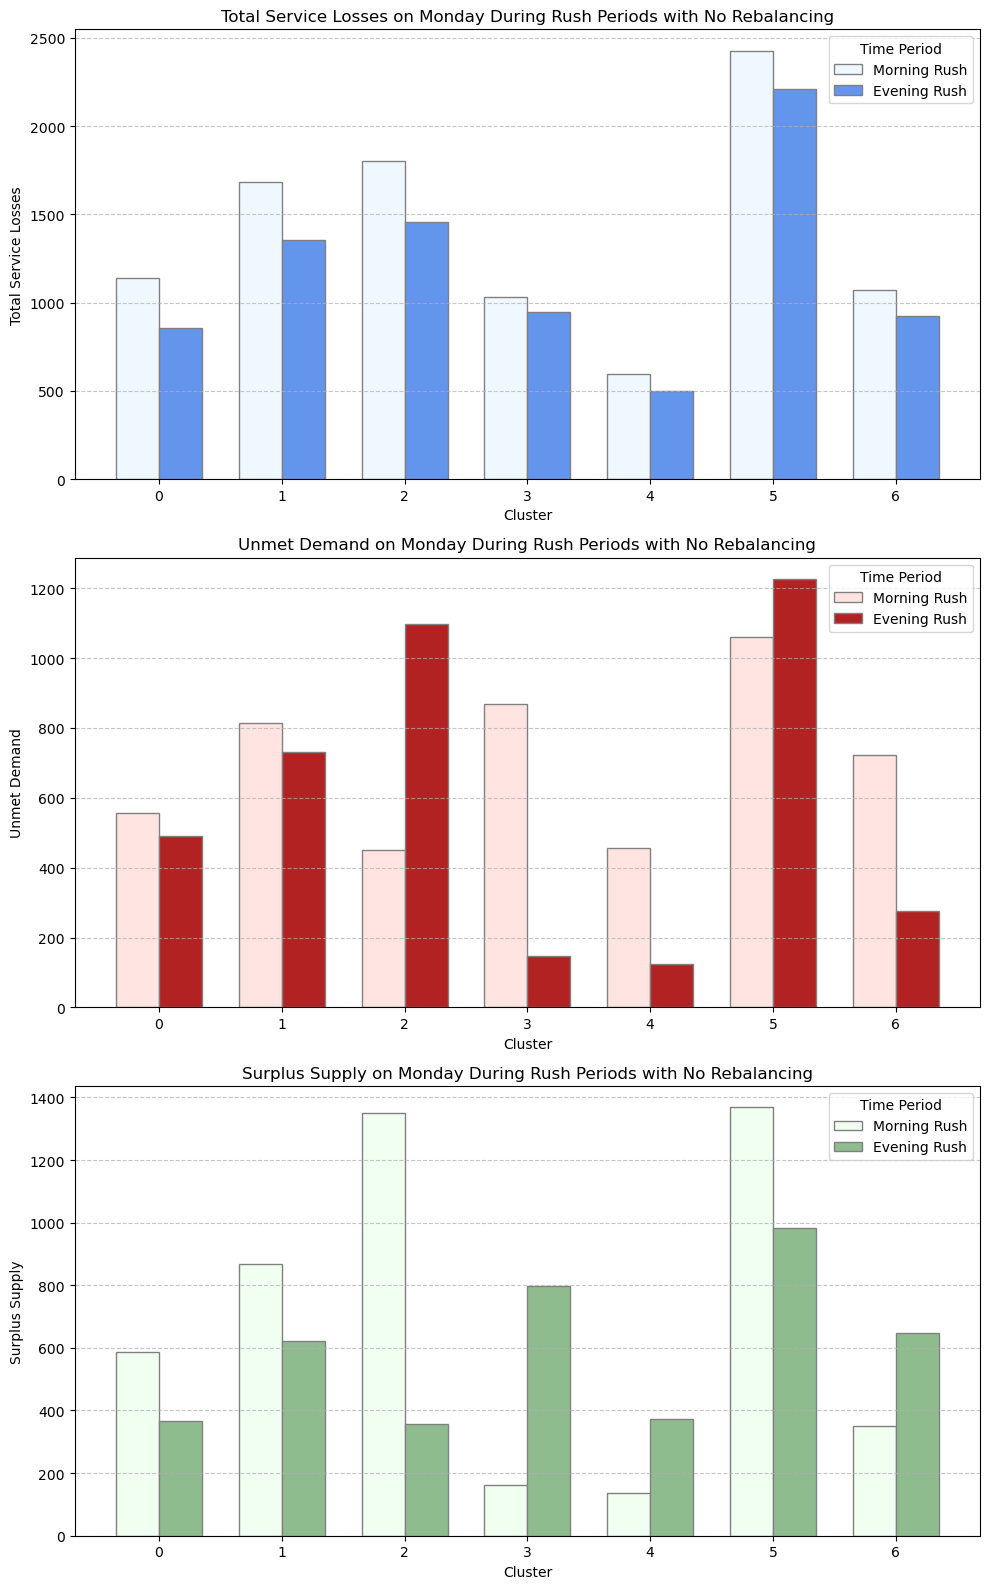

In [35]:
# Monday results no rebalancing
# combine all results
all_results_monday_no_df = pd.concat([
    no_monday_morning_rush_results0, no_monday_morning_rush_results1, no_monday_morning_rush_results2, 
    no_monday_morning_rush_results3, no_monday_morning_rush_results4, no_monday_morning_rush_results5, 
    no_monday_morning_rush_results6, no_monday_evening_rush_results0, no_monday_evening_rush_results1, 
    no_monday_evening_rush_results2, no_monday_evening_rush_results3, no_monday_evening_rush_results4, 
    no_monday_evening_rush_results5, no_monday_evening_rush_results6
])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Evening Rush"]
all_results_monday_no_df["Time Period"] = pd.Categorical(all_results_monday_no_df["Time Period"], categories = time_period_order, ordered = True)

# aggregate data
aggregated_data_loss = all_results_monday_no_df.groupby(["Cluster", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)
aggregated_data_demand = all_results_monday_no_df.groupby(["Cluster", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)
aggregated_data_supply = all_results_monday_no_df.groupby(["Cluster", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)

# define colors for each subplot
color_palettes = [
    ["aliceblue", "cornflowerblue"],
    ["mistyrose", "firebrick"],
    ["honeydew", "darkseagreen"]
]

# create subplots
fig, axes = plt.subplots(3, 1, figsize = (10, 16))

# set width of bars
bar_width = 0.35

# create positions for the bars
r = np.arange(len(aggregated_data_loss))

# plot on separate subplots
for ax, data, title, colors in zip(axes, 
                                   [aggregated_data_loss, aggregated_data_demand, aggregated_data_supply], 
                                   ["Total Service Losses on Monday During Rush Periods with No Rebalancing", "Unmet Demand on Monday During Rush Periods with No Rebalancing", "Surplus Supply on Monday During Rush Periods with No Rebalancing"],
                                   color_palettes):
    for i, period in enumerate(time_period_order):
        ax.bar(r + i * bar_width, data[period], color = colors[i], width = bar_width, edgecolor = "grey", label = period)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(title.split(" on ")[0])
    ax.set_title(title)
    ax.set_xticks(r + bar_width / 2)
    ax.set_xticklabels(data.index)
    ax.legend(title="Time Period")
    ax.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.savefig("monday_total_loss_no.png", dpi = 300, bbox_inches = "tight")
plt.show()

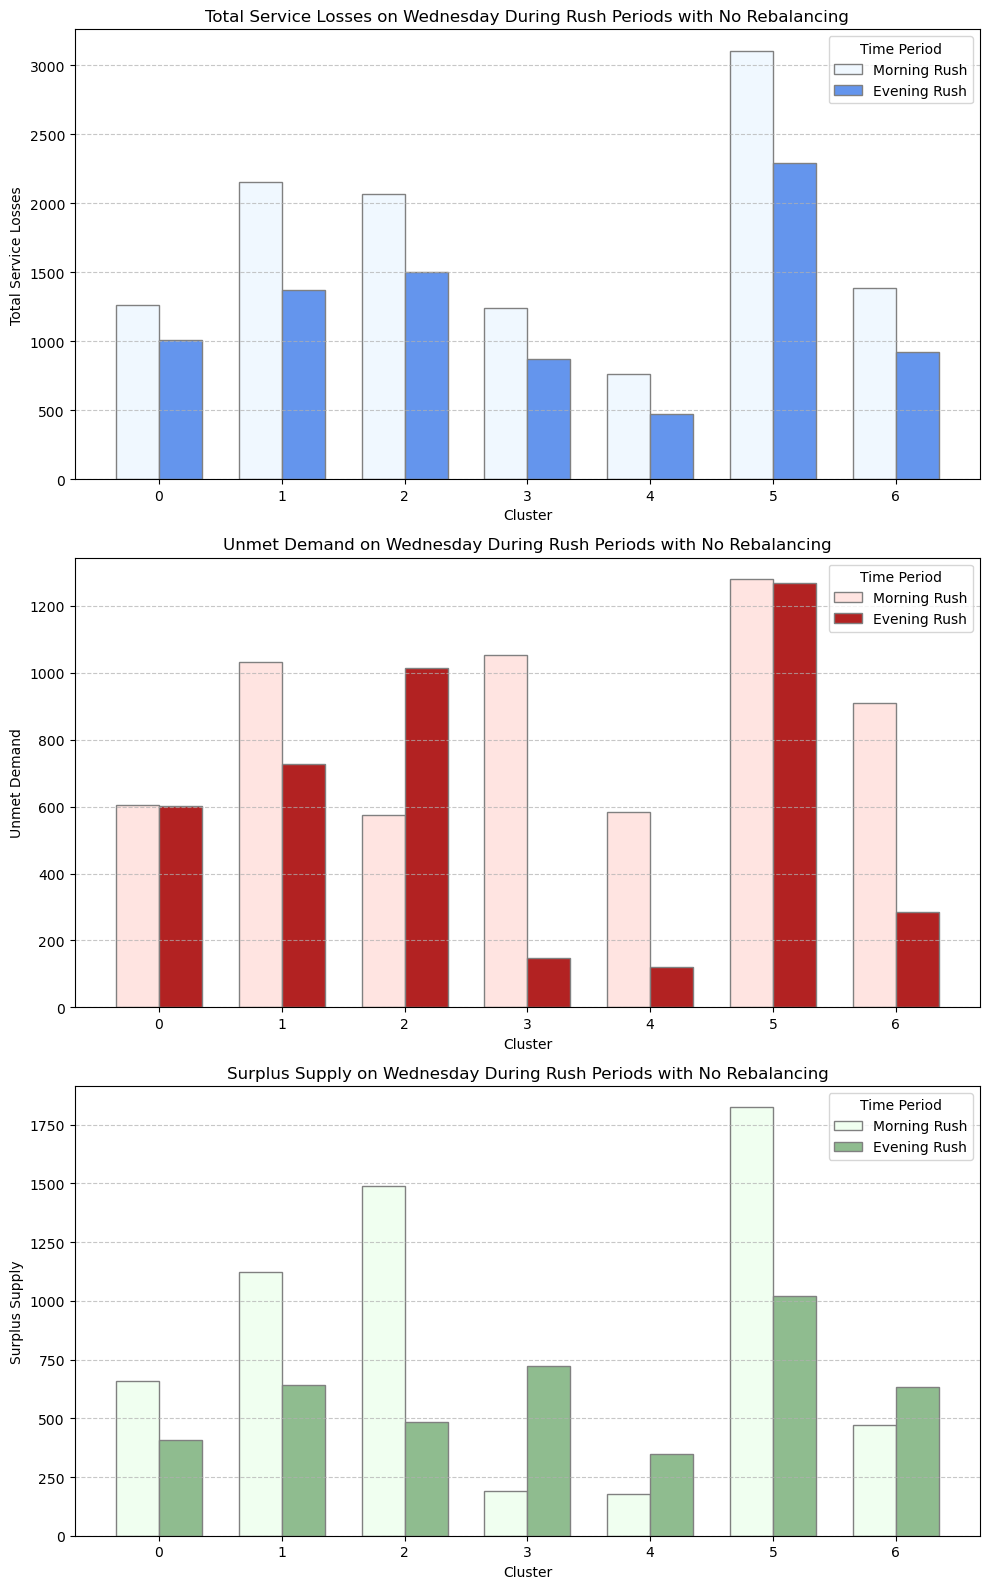

In [36]:
# Wednesday results no rebalancing
# combine all results
all_results_wednesday_no_df = pd.concat([
    no_wednesday_morning_rush_results0, no_wednesday_morning_rush_results1, no_wednesday_morning_rush_results2, 
    no_wednesday_morning_rush_results3, no_wednesday_morning_rush_results4, no_wednesday_morning_rush_results5, 
    no_wednesday_morning_rush_results6, no_wednesday_evening_rush_results0, no_wednesday_evening_rush_results1, 
    no_wednesday_evening_rush_results2, no_wednesday_evening_rush_results3, no_wednesday_evening_rush_results4, 
    no_wednesday_evening_rush_results5, no_wednesday_evening_rush_results6
])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Evening Rush"]
all_results_wednesday_no_df["Time Period"] = pd.Categorical(all_results_wednesday_no_df["Time Period"], categories = time_period_order, ordered = True)

# aggregate data 
aggregated_data_loss = all_results_wednesday_no_df.groupby(["Cluster", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)
aggregated_data_demand = all_results_wednesday_no_df.groupby(["Cluster", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)
aggregated_data_supply = all_results_wednesday_no_df.groupby(["Cluster", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)

# define colors for each subplot
color_palettes = [
    ["aliceblue", "cornflowerblue"],
    ["mistyrose", "firebrick"],
    ["honeydew", "darkseagreen"]
]

# create subplots
fig, axes = plt.subplots(3, 1, figsize = (10, 16))

# Set width of bars
bar_width = 0.35

# create positions for the bars
r = np.arange(len(aggregated_data_loss))

# plot on separate subplots
for ax, data, title, colors in zip(axes, 
                                   [aggregated_data_loss, aggregated_data_demand, aggregated_data_supply], 
                                   ["Total Service Losses on Wednesday During Rush Periods with No Rebalancing", "Unmet Demand on Wednesday During Rush Periods with No Rebalancing", "Surplus Supply on Wednesday During Rush Periods with No Rebalancing"],
                                   color_palettes):
    for i, period in enumerate(time_period_order):
        ax.bar(r + i * bar_width, data[period], color = colors[i], width = bar_width, edgecolor = "grey", label = period)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(title.split(" on ")[0])
    ax.set_title(title)
    ax.set_xticks(r + bar_width / 2)
    ax.set_xticklabels(data.index)
    ax.legend(title="Time Period")
    ax.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.savefig("wednesday_total_loss_no.png", dpi = 300, bbox_inches = "tight")
plt.show()

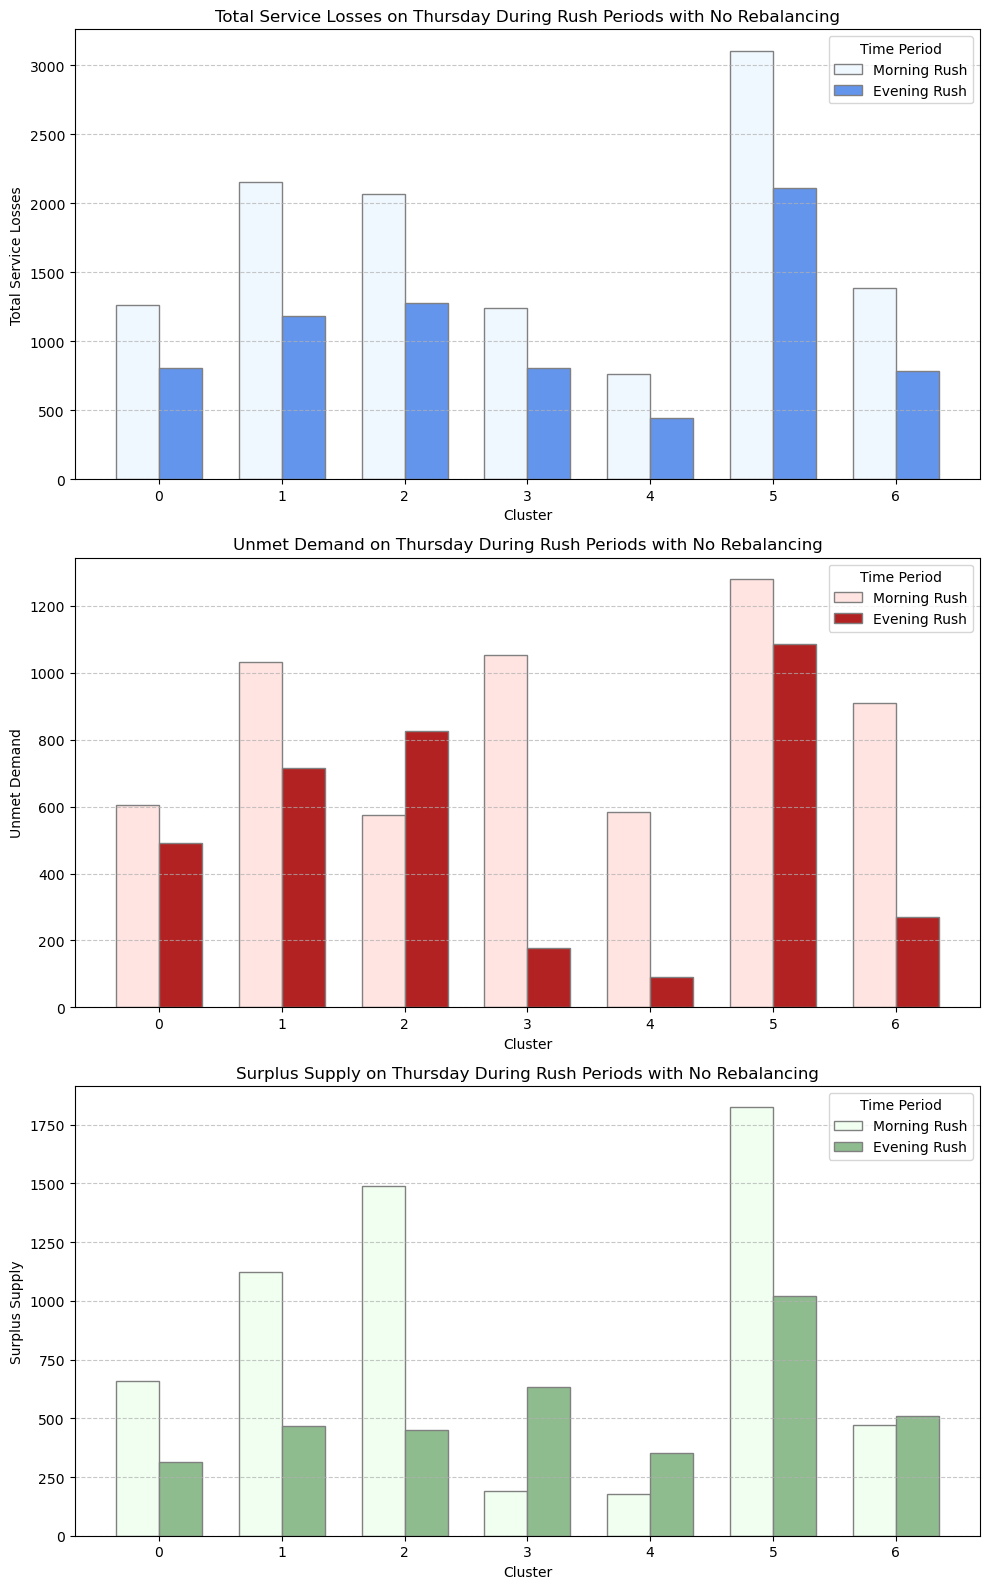

In [37]:
# Thursday results no rebalancing
# combine all results
all_results_thursday_no_df = pd.concat([
    no_thursday_morning_rush_results0, no_thursday_morning_rush_results1, no_thursday_morning_rush_results2, 
    no_thursday_morning_rush_results3, no_thursday_morning_rush_results4, no_thursday_morning_rush_results5, 
    no_thursday_morning_rush_results6, no_thursday_evening_rush_results0, no_thursday_evening_rush_results1, 
    no_thursday_evening_rush_results2, no_thursday_evening_rush_results3, no_thursday_evening_rush_results4, 
    no_thursday_evening_rush_results5, no_thursday_evening_rush_results6
])

# set order for "Time Period" labels
time_period_order = ["Morning Rush", "Evening Rush"]
all_results_thursday_no_df["Time Period"] = pd.Categorical(all_results_thursday_no_df["Time Period"], categories = time_period_order, ordered = True)

# aggregate data
aggregated_data_loss = all_results_thursday_no_df.groupby(["Cluster", "Time Period"], observed = True)["Total Service Loss"].sum().unstack().fillna(0)
aggregated_data_demand = all_results_thursday_no_df.groupby(["Cluster", "Time Period"], observed = True)["Unmet Demand"].sum().unstack().fillna(0)
aggregated_data_supply = all_results_thursday_no_df.groupby(["Cluster", "Time Period"], observed = True)["Surplus Supply"].sum().unstack().fillna(0)

# define colors for each subplot
color_palettes = [
    ["aliceblue", "cornflowerblue"],
    ["mistyrose", "firebrick"],
    ["honeydew", "darkseagreen"]
]

# create subplots
fig, axes = plt.subplots(3, 1, figsize = (10, 16))

# set width of bars
bar_width = 0.35

# create positions for the bars
r = np.arange(len(aggregated_data_loss))

# plot on separate subplots
for ax, data, title, colors in zip(axes, 
                                   [aggregated_data_loss, aggregated_data_demand, aggregated_data_supply], 
                                   ["Total Service Losses on Thursday During Rush Periods with No Rebalancing", "Unmet Demand on Thursday During Rush Periods with No Rebalancing", "Surplus Supply on Thursday During Rush Periods with No Rebalancing"],
                                   color_palettes):
    for i, period in enumerate(time_period_order):
        ax.bar(r + i * bar_width, data[period], color = colors[i], width = bar_width, edgecolor = "grey", label = period)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(title.split(" on ")[0])
    ax.set_title(title)
    ax.set_xticks(r + bar_width / 2)
    ax.set_xticklabels(data.index)
    ax.legend(title="Time Period")
    ax.grid(axis = "y", linestyle = "--", alpha = 0.7)

plt.tight_layout()
plt.savefig("thursday_total_loss_no.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [40]:
aggregated_data_total_monday = all_results_monday_df["Total Service Loss"].sum()
aggregated_data_total_wednesday = all_results_wednesday_df["Total Service Loss"].sum()
aggregated_data_total_thursday = all_results_thursday_df["Total Service Loss"].sum()

aggregated_data_ud_monday = all_results_monday_df["Unmet Demand"].sum()
aggregated_data_ud_wednesday = all_results_wednesday_df["Unmet Demand"].sum()
aggregated_data_ud_thursday = all_results_thursday_df["Unmet Demand"].sum()

aggregated_data_ss_monday = all_results_monday_df["Surplus Supply"].sum()
aggregated_data_ss_wednesday = all_results_wednesday_df["Surplus Supply"].sum()
aggregated_data_ss_thursday = all_results_thursday_df["Surplus Supply"].sum()

aggregated_data_total_monday_no = all_results_monday_no_df["Total Service Loss"].sum()
aggregated_data_total_wednesday_no = all_results_wednesday_no_df["Total Service Loss"].sum()
aggregated_data_total_thursday_no = all_results_thursday_no_df["Total Service Loss"].sum()

aggregated_data_ud_monday_no = all_results_monday_no_df["Unmet Demand"].sum()
aggregated_data_ud_wednesday_no = all_results_wednesday_no_df["Unmet Demand"].sum()
aggregated_data_ud_thursday_no = all_results_thursday_no_df["Unmet Demand"].sum()

aggregated_data_ss_monday_no = all_results_monday_no_df["Surplus Supply"].sum()
aggregated_data_ss_wednesday_no = all_results_wednesday_no_df["Surplus Supply"].sum()
aggregated_data_ss_thursday_no = all_results_thursday_no_df["Surplus Supply"].sum()


total_service_loss_with_rebalance = np.mean(aggregated_data_total_monday.sum().sum() + aggregated_data_total_wednesday.sum().sum() + aggregated_data_total_thursday.sum().sum())
total_service_loss_no_rebalance = np.mean(aggregated_data_total_monday_no.sum().sum() + aggregated_data_total_wednesday_no.sum().sum() + aggregated_data_total_thursday_no.sum().sum())

unmet_demand_with_rebalance = np.mean(aggregated_data_ud_monday.sum().sum() + aggregated_data_ud_wednesday.sum().sum() + aggregated_data_ud_thursday.sum().sum())
unmet_demand_no_rebalance = np.mean(aggregated_data_ud_monday_no.sum().sum() + aggregated_data_ud_wednesday_no.sum().sum() + aggregated_data_ud_thursday_no.sum().sum())

surplus_supply_with_rebalance = np.mean(aggregated_data_ss_monday.sum().sum() + aggregated_data_ss_wednesday.sum().sum() + aggregated_data_ss_thursday.sum().sum())
surplus_supply_no_rebalance = np.mean(aggregated_data_ss_monday_no.sum().sum() + aggregated_data_ss_wednesday_no.sum().sum() + aggregated_data_ss_thursday_no.sum().sum())

overall_percent_change_total = ((total_service_loss_with_rebalance - total_service_loss_no_rebalance) / total_service_loss_no_rebalance) * 100
overall_percent_change_unmet_demand = ((unmet_demand_with_rebalance - unmet_demand_no_rebalance) / unmet_demand_no_rebalance) * 100
overall_percent_change_surplus_supply = ((surplus_supply_with_rebalance - surplus_supply_no_rebalance) / surplus_supply_no_rebalance) * 100

print("The total service loss has decreased by", np.round(overall_percent_change_total, 2), "%")
print("Unmet demand has decreased by", np.round(overall_percent_change_unmet_demand, 2), "%")
print("Surplus supply has decreased by", np.round(overall_percent_change_surplus_supply, 2), "%")

The total service loss has decreased by -70.74 %
Unmet demand has decreased by -72.53 %
Surplus supply has decreased by -68.94 %
